<center><h1> DOSSIER SVM ET RESEAUX DE NEURONES 




<h2> Carles CERDÁ VILA - M2 ECAP

<h4> 2022-23

## Etape d'importation

In [141]:
#Explore environnement 
import os
#Data management
import pandas as pd
import numpy as np
import time
#Graphique
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
from imblearn.under_sampling import RandomUnderSampler 

In [108]:
#Outliers
from scipy import stats
#Performance indicators
from sklearn import metrics

In [4]:
#Modélisation 
#Classifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC 
from sklearn.linear_model import SGDClassifier , LogisticRegression
#Multiclass strategie
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
#Regressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
#Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#Eval
from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV
from sklearn_evaluation import plot

In [161]:
#Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [5]:
from pandas_profiling import ProfileReport
#Web request
import requests
import io

C:\Users\carle\AppData\Local\Temp\ipykernel_13428\2785702059.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


### Function

In [6]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    
    '''
    
    SEULEMENT pour la fonction SVC de sklearn, pas de LINEARSVC
    
    Function qui permet de recupérer la constante et le coefficient directeur
    d'un svm après entraintement.
    
    Un svm lineaire est de la forme w0*w0+w1*x1 +b =0
    donc 
    >= x1= -w0/w1 *x0 -b/w1
    
    avoir x1 en fonction de x0 permet de tracer la zone de décision du SVM 
    et ainsi avoir une réprésentation graphique
    
    Pour calculer les marges on rajoute +- 1/w[1]
    
    
    '''
    
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [7]:
def svm_f_importances(coef_svm , names):
    ''' 
    Cette fonction permet de visualiser l'importance de chaque variable pour le modèle SVM
    Vous devez passer 2 arguments :
    
    - coef_svm : Les coéfficients du modèle disponible après votre .fit()
      On le récupère avec la commande suite  svc_fit.coef_[0]
      
    - names : est le nom des features que vous avez utilisée.
      ATTENTION à passer dans le même ordre que pour l'entrainement du modèle
    
    '''
    imp = coef_svm
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

#features_names = ['input1', 'input2']
#svm = svm.SVC(kernel='linear')
#svm.fit(X, Y)
#f_importances(svm.coef_[0], features_names)

In [ ]:
def plot_predictions(clf, axes):
    
    ''''
    Plot prediction permet de visualiser la frontière de décision d'un SVM avec kernel.
    Elle ne marche qu'avec 2 features (2 dimensions)
    
    IL FAUT également tracer votre X_train avant de faire cette fonction!!
    
    '''
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    

#clf = model SVC
#axes = [xlim_min, xlim_max, ylim_min, ylim_max]

In [8]:
#Test de Grubbs
def grubbs_stat(y):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    Gcal = max_of_deviations/ std_dev
    print("Grubbs Statistics Value : {}".format(Gcal))
    return Gcal, max_ind

In [9]:
#Valeur critique pour une variable
def calculate_critical_value(size, alpha):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print("Grubbs Critical Value: {}".format(critical_value))
    return critical_value

In [10]:
#ESD test
def ESD_Test(input_series, alpha, max_outliers):
    input_series = np.array(input_series) #Transformation de la colonne en array
    
    #Initialisation des valeurs
    nb_outliers=0
    valeur_atypique_seuil="-"

    
    #Itération pour chaque valeur de la série
    for iterations in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
        
        #Récupère les valeurs de la dernière itération où la valeur est considéré comme atypique
        if round(Gstat,4)>round(Gcritical,4) :
            nb_outliers+=1
            valeur_atypique_seuil=input_series[max_index]
            last_Gstat=Gstat
            last_Gcritical=Gcritical
        
        #Supprime la valeur de l'itération pour tester sur d'autres
        input_series = np.delete(input_series, max_index)
   
    #Print des résultats du test
    print("Nombre de valeurs atypiques : "+ str(nb_outliers))
    print("Valeur atypique seuil : {}".format(valeur_atypique_seuil))
    
    if nb_outliers>0 :
        print('{} is an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(valeur_atypique_seuil, last_Gstat, last_Gcritical))
    
    if (max_outliers*0.8)<nb_outliers : #Marge de sécurité
        print('\033[1m' + "Veuillez augmenter le nombre d'outlier max par sécurité"+'\033[0m')
    
    return valeur_atypique_seuil

On importe le jeu de données de _Census Income Data Set_, qui a été téléchargé par _Data Science Dojo_. Il s'agit d'une base de données qui vise à estimer si le revenu d'une personne dépasse 50 000 $/an. On a un fichier correspondant à la base de données d'entraînement (__train__) et un autre pour la base de données de validation (__test__).

In [11]:
#Importation du jeu de données d'apprentissage
train = pd.read_table("C:/Users/carle/OneDrive/Escritorio/M2 ECAP/SVM et réseaux de neurones/Dossier SVM et réseaux de neurones/adultdata.txt",
                     sep = ",",
                     header = 0, 
                     na_values = " ?",
                     engine = "python")

#Importation du jeu de données de test
test = pd.read_table("C:/Users/carle/OneDrive/Escritorio/M2 ECAP/SVM et réseaux de neurones/Dossier SVM et réseaux de neurones/adulttest.txt",
                     sep = ",",
                     header = 0, 
                     na_values = " ?",
                     engine = "python")

In [12]:
#On renomme les colonnes
features_names = list(train.columns)

In [13]:
features_names

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'income']

In [14]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


On doit faire quelques transformations sur les variables afin d'obtenir le type le plus pertinent

In [16]:
#Variables qualitatives
for col in [
    'workclass','education','marital-status','occupation','relationship','race','sex','native-country','income'
]: train[col] = train[col].astype('category')
    
for col in [
    'workclass','education','marital-status','occupation','relationship','race','sex','native-country','income'
]: test[col] = test[col].astype('category')

En raison de la nature de certaines variables, on a dû les transformer d'_integer_ en _floating_. C'est parce qu'elles peuvent obtenir des valeurs décimales.

In [17]:
#Variables quantitatives continues
for col in [
    'capital-gain','capital-loss','hours-per-week'
]: train[col] = train[col].astype('float64')
    
for col in [
    'capital-gain','capital-loss','hours-per-week'
]: test[col] = test[col].astype('float64')

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       30725 non-null  category
 2   fnlwgt          32561 non-null  int64   
 3   education       32561 non-null  category
 4   education-num   32561 non-null  int64   
 5   marital-status  32561 non-null  category
 6   occupation      30718 non-null  category
 7   relationship    32561 non-null  category
 8   race            32561 non-null  category
 9   sex             32561 non-null  category
 10  capital-gain    32561 non-null  float64 
 11  capital-loss    32561 non-null  float64 
 12  hours-per-week  32561 non-null  float64 
 13  native-country  31978 non-null  category
 14  income          32561 non-null  category
dtypes: category(9), float64(3), int64(3)
memory usage: 1.8 MB


## 1. Analyse exploratoire sur le jeu de données (EDA)
    
Dans cette partie on effectuera l'analyse univariée et multivariée des variables pour visualiser la distribution des données et les corrélations entre variables. En outre, on identifiera les valeurs manquantes et les _outliers_. Nous déciderons comment traiter ce genre de valeurs.

### 1.1. Analyse sur les variables

#### A) Analyse univariée

In [19]:
#On commencera par diviser les variables en deux groupes : variables quantitatives et qualitatives
quant = pd.DataFrame(data=train, columns=['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week'])

quali = pd.DataFrame(data=train,
        columns=['workclass','education','marital-status','occupation','relationship','race','sex','native-country'])

On visualise d'abord les statistiques descriptives pour les variables quantitatives.

In [20]:
round(quant.describe(),1)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.0,32561.0,32561.0,32561.0,32561.0,32561.0
mean,38.6,189778.4,10.1,1077.6,87.3,40.4
std,13.6,105550.0,2.6,7385.3,403.0,12.3
min,17.0,12285.0,1.0,0.0,0.0,1.0
25%,28.0,117827.0,9.0,0.0,0.0,40.0
50%,37.0,178356.0,10.0,0.0,0.0,40.0
75%,48.0,237051.0,12.0,0.0,0.0,45.0
max,90.0,1484705.0,16.0,99999.0,4356.0,99.0


In [21]:
profile_quant = ProfileReport(quant)
#On exporte les résultats dans un fichier html
profile_quant.to_file('pandas_quant.html')

In [22]:
profile_quant

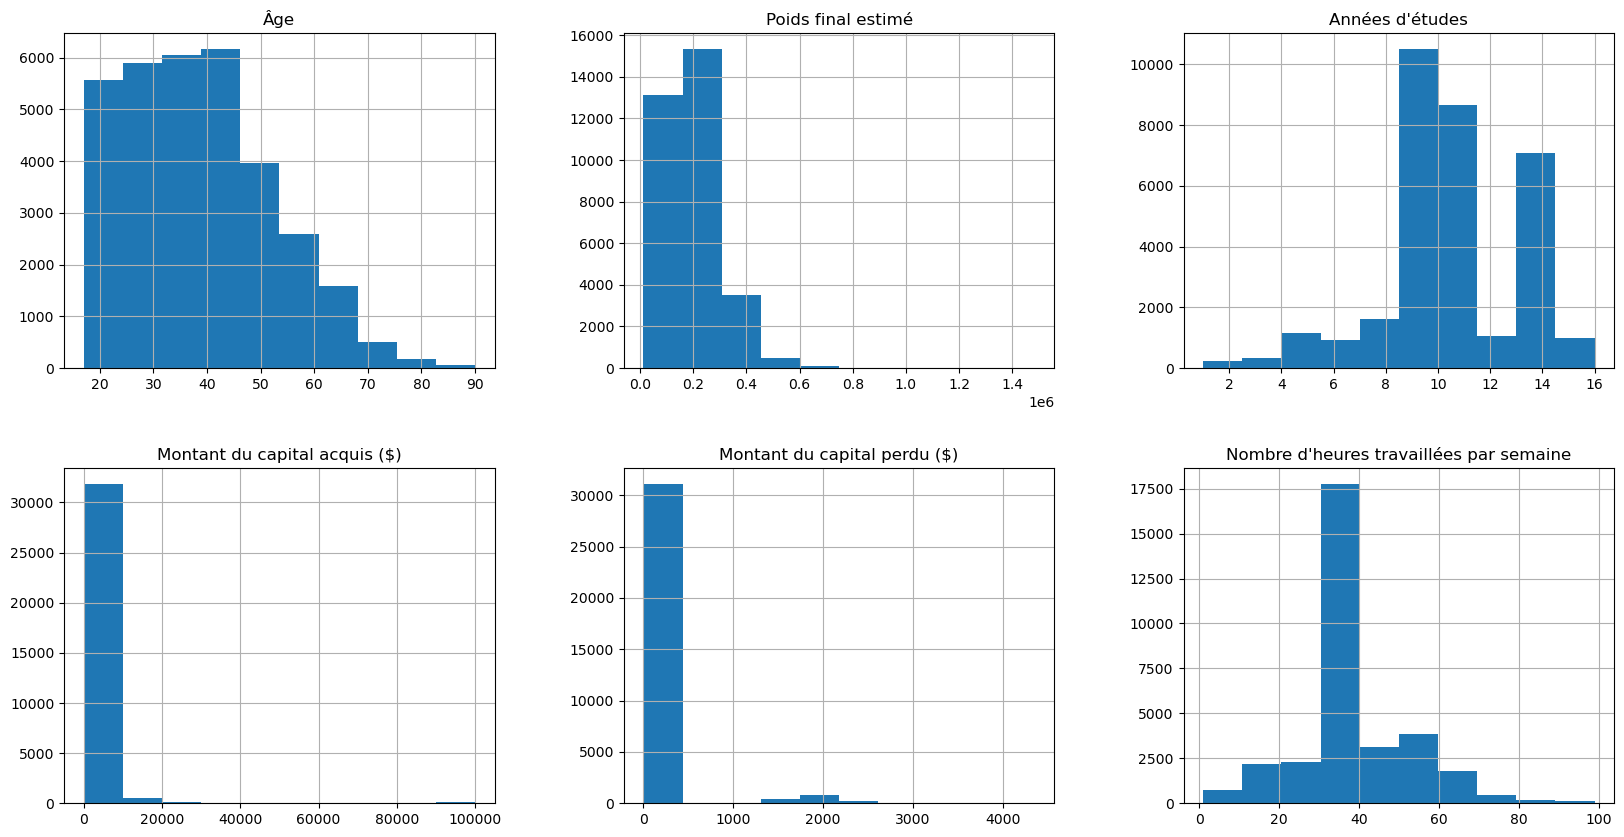

In [21]:
#Histogrammes pour les variables quantitatives
plt.rcParams["figure.figsize"] = (20,10)

figure, axes = plt.subplots(2,3)

quant.hist('age', ax = axes[0,0])
axes[0,0].set_title("Âge")
quant.hist('fnlwgt', ax = axes[0,1])
axes[0,1].set_title("Poids final estimé")
quant.hist('education-num', ax = axes[0,2])
axes[0,2].set_title("Années d'études")

quant.hist('capital-gain', ax = axes[1,0])
axes[1,0].set_title("Montant du capital acquis ($)")
quant.hist('capital-loss', ax = axes[1,1])
axes[1,1].set_title("Montant du capital perdu ($)")
quant.hist('hours-per-week', ax = axes[1,2])
axes[1,2].set_title("Nombre d'heures travaillées par semaine")

plt.show()

On continue avec les variables qualitatives

In [22]:
quali.describe()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,30725,32561,32561,30718,32561,32561,32561,31978
unique,8,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,22696,10501,14976,4140,13193,27816,21790,29170


In [25]:
profile_quali = ProfileReport(quali)
#On exporte les résultats dans un fichier html
profile_quali.to_file('pandas_quali.html')

In [26]:
profile_quali

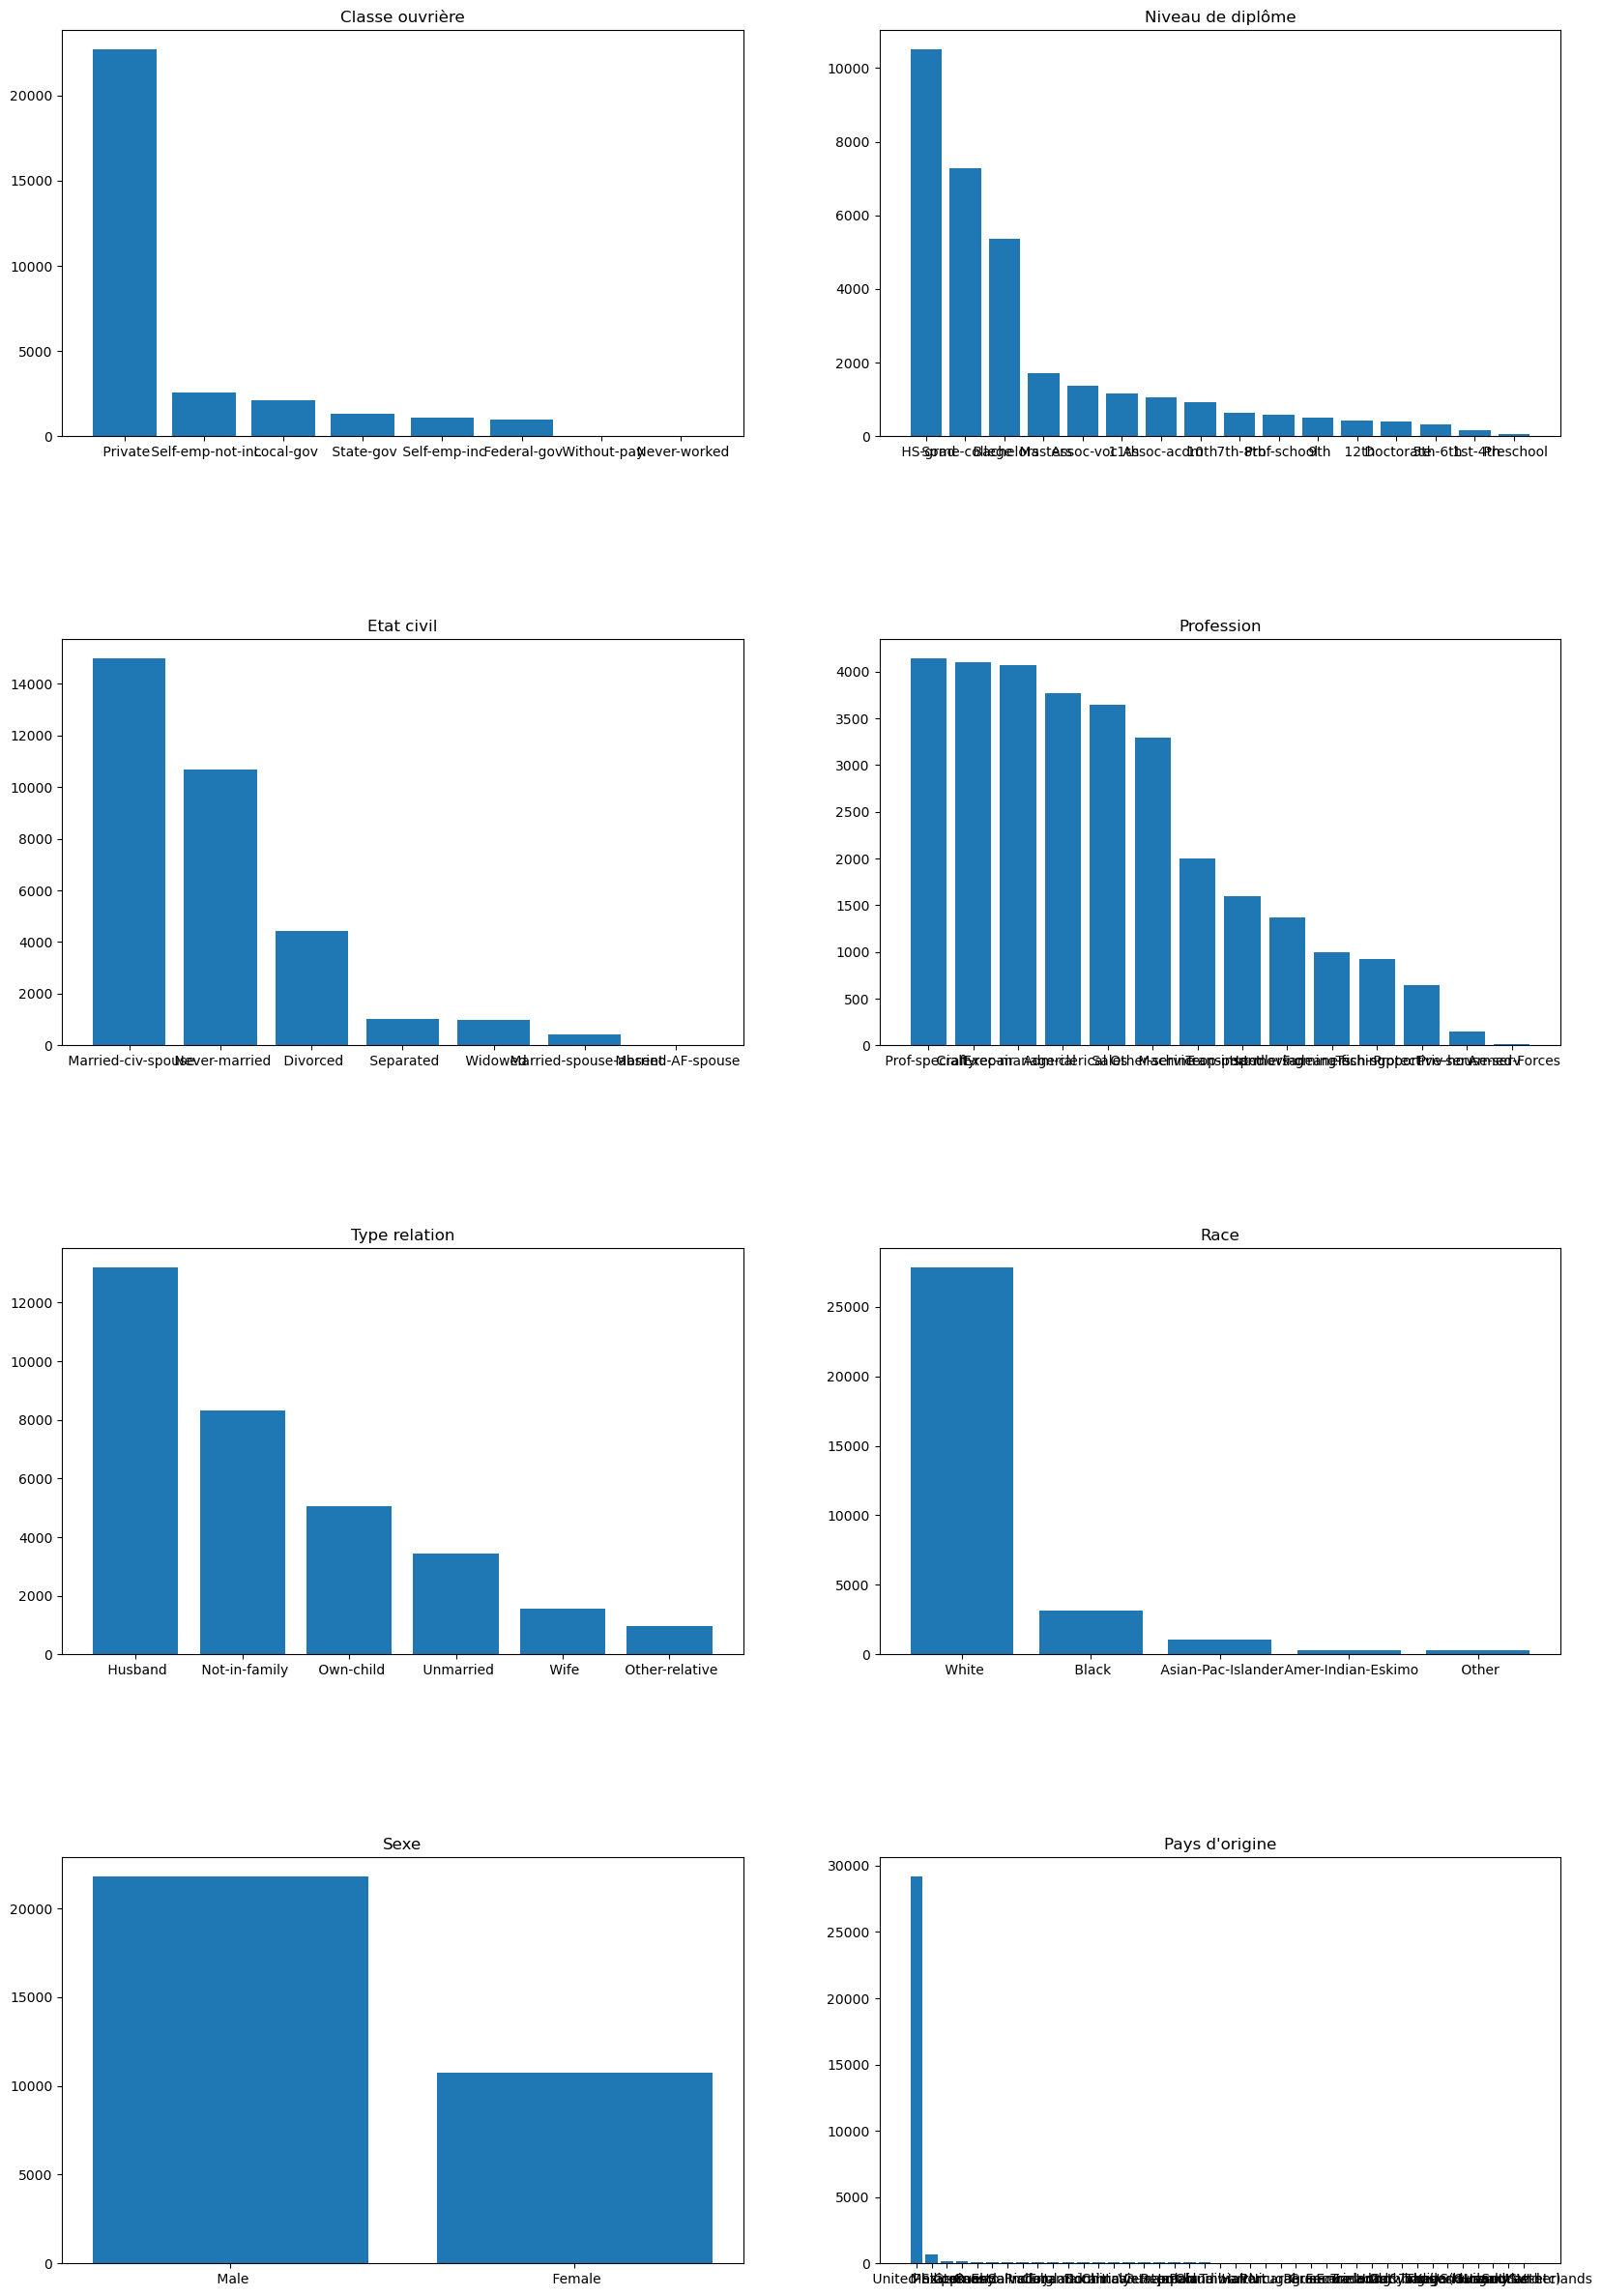

In [23]:
#Barplots pour les variables qualitatives
plt.rcParams["figure.figsize"] = (20,30)

figure, axes = plt.subplots(4,2)
plt.subplots_adjust(hspace = 0.5)

axes[0,0].bar(quali.workclass.value_counts().index, quali.workclass.value_counts().values) 
axes[0,0].set_title('Classe ouvrière') 
axes[0,1].bar(quali.education.value_counts().index, quali.education.value_counts().values) 
axes[0,1].set_title('Niveau de diplôme')

axes[1,0].bar(quali['marital-status'].value_counts().index, quali['marital-status'].value_counts().values) 
axes[1,0].set_title("Etat civil") 
axes[1,1].bar(quali.occupation.value_counts().index, quali.occupation.value_counts().values) 
axes[1,1].set_title('Profession')

axes[2,0].bar(quali.relationship.value_counts().index, quali.relationship.value_counts().values) 
axes[2,0].set_title('Type relation') 
axes[2,1].bar(quali.race.value_counts().index, quali.race.value_counts().values) 
axes[2,1].set_title('Race')

axes[3,0].bar(quali.sex.value_counts().index, quali.sex.value_counts().values) 
axes[3,0].set_title("Sexe") 
axes[3,1].bar(quali['native-country'].value_counts().index, quali['native-country'].value_counts().values) 
axes[3,1].set_title("Pays d'origine")

plt.show()

Après le graphique ci-dessus, nous avons décidé de transformer la variable __*native-country*__ pour une variable qui indique si un individu est né aux Etats-Unis ou à l'étranger. Nous faisons cela parce que nous pensons que cette division peut être plus intéressante que d'avoir tous les différents pays. Il peut être plus déterminant de savoir si quelqu'un est né aux Etats-Unis ou ailleurs que de savoir s'il est spécifiquement né au Bangladesh ou en Chine.

In [24]:
def create_new_variable(country):
    if country == ' United-States':
        return 'born_us'
    else:
        return 'born_abroad'

train['born'] = train['native-country'].apply(create_new_variable)

test['born'] = test['native-country'].apply(create_new_variable)

In [25]:
train['born'] = train['born'].astype('category')

test['born'] = test['born'].astype('category')

In [26]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,born
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,born_us
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,born_us
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,born_us
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,born_us
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,born_abroad


In [27]:
#On supprrime la variable qui va être remplacée
train.drop(["native-country"], axis = 1, inplace = True)

test.drop(["native-country"], axis = 1, inplace = True)

In [28]:
features_names = list(train.columns)

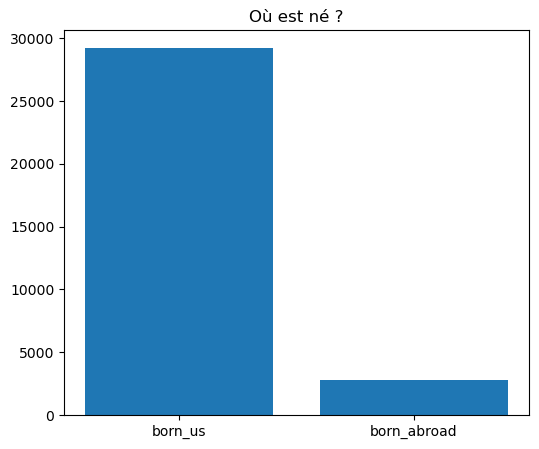

In [29]:
plt.rcParams["figure.figsize"] = (6,5)

plt.bar(
    train.born.value_counts().index,
    train.born.value_counts().values
)
plt.title("Où est né ?")
plt.show()

In [30]:
#N'oubliez pas la variable cible
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

#from plotly.offline import iplot
import plotly.graph_objects as go

label = train["income"].value_counts().index
valeurs = train["income"].value_counts().values
colors = ['#03045E','#90E0EF']

# Création de l'object graphique
fig = go.Figure()

# Ajout d'une trace
fig.add_trace(go.Pie(
    labels = label,
    values = valeurs,
    pull=[0, 0.2] #Pour mettre en avant un label 
))

fig.update_layout(
    title_text="Revenu de l'échantillon",
    title_font = dict(size = 35, color = "black"),
    title_x = 0.5,
)

fig.update_traces(
    hoverinfo='label+percent', # Affichage du label et de la fréquence au moment du passage de la souris
    textinfo='value',  #  Affichage du la valeur des tranches
    textfont_size=20, # Taille du textinfo
    marker=dict(colors=colors) # Couleur des label
)

fig.show()

#### B) Analyse multivariée

In [31]:
#On trace la matrice de corrélations pour les variables quantitatives
corr = quant.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.078141,0.066345,0.124948,0.058484,0.142907
fnlwgt,-0.078141,1.000000,-0.035706,-0.006039,-0.006914,-0.021621
education-num,0.066345,-0.035706,1.000000,0.119140,0.074749,0.167215
capital-gain,0.124948,-0.006039,0.119140,1.000000,-0.066569,0.093322
capital-loss,0.058484,-0.006914,0.074749,-0.066569,1.000000,0.059852
hours-per-week,0.142907,-0.021621,0.167215,0.093322,0.059852,1.000000


In [32]:
m_corr = train[features_names].corr()
fig = plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(m_corr[abs(m_corr)>=0.80],annot = True, fmt = '.2f')

<AxesSubplot:>

Aucune variable quantitative n'est significativement corrélée.

In [33]:
quali = pd.DataFrame(data=train,
        columns=['workclass','education','marital-status','occupation','relationship','race','sex','born'])

In [34]:
# Import association_metrics  
import association_metrics as am

# On calcule la corrélation par Cramer's V
cramersv = am.CramersV(quali) 
# Voici la matrice des corrélations
cramersv.fit()

,workclass,education,marital-status,occupation,relationship,race,sex,born
workclass,1.000000,0.102225,0.077788,0.216008,0.089828,0.056970,0.143928,0.053312
education,0.102225,1.000000,0.091569,0.197449,0.122654,0.074900,0.095621,0.299973
marital-status,0.077788,0.091569,1.000000,0.131502,0.487963,0.084219,0.461827,0.119983
occupation,0.216008,0.197449,0.131502,1.000000,0.177980,0.082798,0.434261,0.120039
relationship,0.089828,0.122654,0.487963,0.177980,1.000000,0.098099,0.649000,0.120730
race,0.056970,0.074900,0.084219,0.082798,0.098099,1.000000,0.118115,0.399158
sex,0.143928,0.095621,0.461827,0.434261,0.649000,0.118115,1.000000,0.001289
born,0.053312,0.299973,0.119983,0.120039,0.120730,0.399158,0.001289,1.000000


Seule la variable __*relationship*__ est corrélée avec la variable __*sex*__. Cependant, cette corrélation n'est pas alarmante. Elle est inférieure à 0,65. Pour cette raison, nous conserverons toutes les variables.

### 1.2. Valeurs manquantes

In [35]:
na = train.isna().sum()/train.shape[0]*100
na.sort_values()

age               0.000000
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
income            0.000000
born              1.790486
workclass         5.638647
occupation        5.660146
dtype: float64

In [36]:
na = test.isna().sum()/test.shape[0]*100
na.sort_values()

age               0.000000
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
income            0.000000
born              1.682943
workclass         5.914870
occupation        5.933296
dtype: float64

Il n'y a pas un grand nombre de valeurs manquantes dans les ensembles de données. Pour cette raison, nous remplacerons ces valeurs manquantes par le mode des variables. Dans le cas où ce nombre serait plus important, nous devrions repenser notre approche.

In [37]:
#Jeu d'apprentissage
train['born'].fillna(train.born.mode()[0], inplace = True)
train['workclass'].fillna(train.workclass.mode()[0], inplace = True)
train['occupation'].fillna(train.occupation.mode()[0], inplace = True)
#Jeu de test
test['born'].fillna(test.born.mode()[0], inplace = True)
test['workclass'].fillna(test.workclass.mode()[0], inplace = True)
test['occupation'].fillna(test.occupation.mode()[0], inplace = True)

In [38]:
missing_values = train.isnull().sum().sum()

# Si la variable a plus de 0 valeurs manquantes, il y aura donc des valeurs manquantes dans le jeu de données
if missing_values > 0:
    print("Il y a des valeurs manquantes pour le jeu d'apprentissage.")
else:
    print("Il n'y a pas des valeurs manquantes pour le jeu d'apprentissage.")

Il n'y a pas des valeurs manquantes pour le jeu d'apprentissage.


In [39]:
missing_values = test.isnull().sum().sum()

# Si la variable a plus de 0 valeurs manquantes, il y aura donc des valeurs manquantes dans le jeu de données
if missing_values > 0:
    print("Il y a des valeurs manquantes pour le jeu de test.")
else:
    print("Il n'y a pas des valeurs manquantes pour le jeu de test.")

Il n'y a pas des valeurs manquantes pour le jeu de test.


### 1.3. Outliers

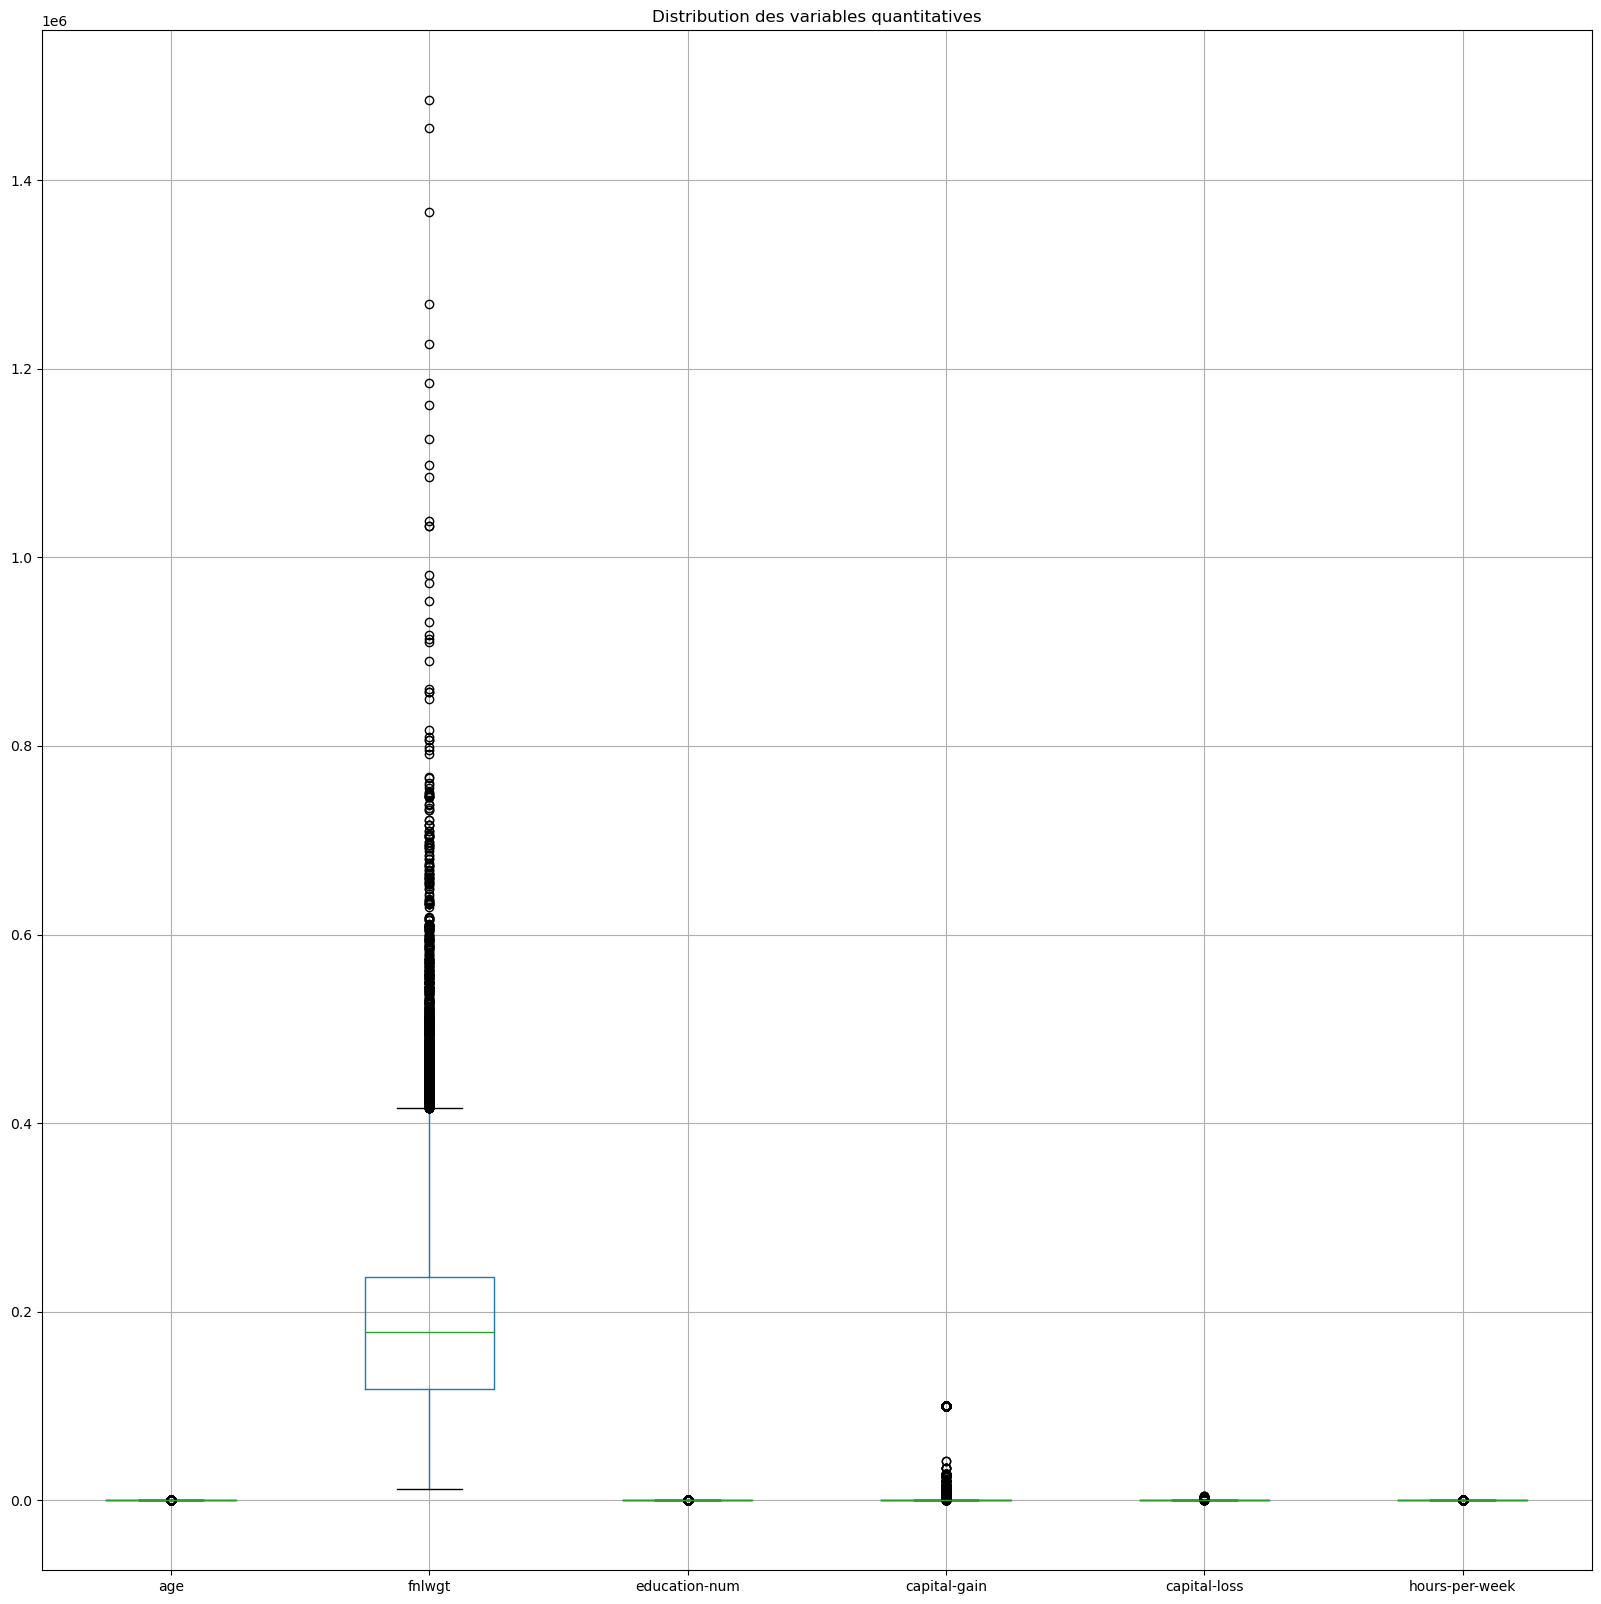

In [40]:
#On va observer si les variables quantitatives ont des outliers
plt.rcParams["figure.figsize"] = (20,20)

quant.boxplot()
plt.title("Distribution des variables quantitatives")
plt.show()

En raison de l'échelle du poids final, nous ne pouvons pas apprécier si les autres variables ont des points atypiques. Nous allons analyser dans un premier étape la variable __*fnlwgt*__, puis la variable __*capital-gain*__ et enfin toutes les variables restantes.

<AxesSubplot:xlabel='fnlwgt'>

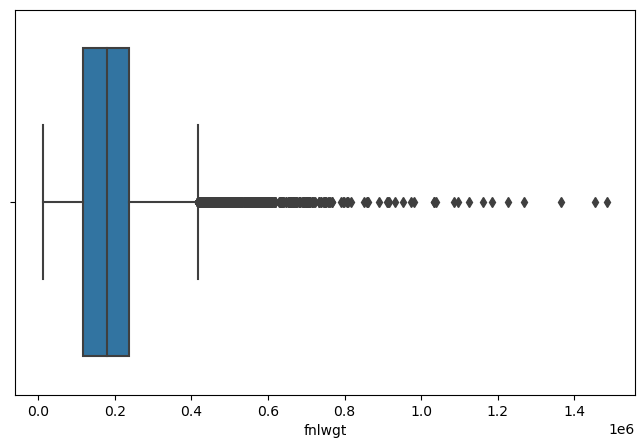

In [41]:
#Boxplot de fnlwgt
plt.rcParams["figure.figsize"] = (8,5)

sns.boxplot(x=quant["fnlwgt"])

On peut souligner l'abondance de valeurs aberrantes potentielles pour cette variable. Nous effectuerons le test de Grubbs pour nous assurer qu'il y a au moins un point atypique dans la série et si oui, nous verrons combien de points de cette nature utilisent le test ESD.

In [42]:
#Test de Grubbs
grubbs_stat(quant['fnlwgt'])

Grubbs Statistics Value : 12.26856269254113


(12.26856269254113, 14449)

In [43]:
#P-value
calculate_critical_value(32561,0.05)

Grubbs Critical Value: 4.805733265862579


4.805733265862579

La valeur statistique obtenue est superièure à la valeur théorique pour 32561 observations avec une p-value de 5%. Il y a donc d'_outliers_ dans cette variable.

In [44]:
#Test ESD
ESD_Test(quant['fnlwgt'] , 0.05, 1000)

Grubbs Critical Value: 4.805733265862579
Grubbs Statistics Value : 12.26856269254114
Grubbs Critical Value: 4.805727101102189
Grubbs Statistics Value : 12.019255050709987
Grubbs Critical Value: 4.805720936174861
Grubbs Statistics Value : 11.196169162404626
Grubbs Critical Value: 4.8057147710228065
Grubbs Statistics Value : 10.28557864113052
Grubbs Critical Value: 4.805708605674955
Grubbs Statistics Value : 9.903687421067
Grubbs Critical Value: 4.8057024401313235
Grubbs Statistics Value : 9.517433762821794
Grubbs Critical Value: 4.8056962743919405
Grubbs Statistics Value : 9.308068678910306
Grubbs Critical Value: 4.805690108456824
Grubbs Statistics Value : 8.97775021308863
Grubbs Critical Value: 4.8056839423260005
Grubbs Statistics Value : 8.718614174377503
Grubbs Critical Value: 4.805677775999487
Grubbs Statistics Value : 8.614177709477193
Grubbs Critical Value: 4.8056716094773115
Grubbs Statistics Value : 8.172159427454734
Grubbs Critical Value: 4.80566544275949
Grubbs Statistics Valu

Grubbs Critical Value: 4.804917809226757
Grubbs Statistics Value : 4.256104020032525
Grubbs Critical Value: 4.804911618318144
Grubbs Statistics Value : 4.25686266191341
Grubbs Critical Value: 4.804905427245435
Grubbs Statistics Value : 4.247512154985822
Grubbs Critical Value: 4.804899235951068
Grubbs Statistics Value : 4.242264774646319
Grubbs Critical Value: 4.8048930444638565
Grubbs Statistics Value : 4.237335600763614
Grubbs Critical Value: 4.804886852783824
Grubbs Statistics Value : 4.228791567748688
Grubbs Critical Value: 4.8048806609109915
Grubbs Statistics Value : 4.229709103000626
Grubbs Critical Value: 4.8048744688165925
Grubbs Statistics Value : 4.2296637625684
Grubbs Critical Value: 4.80486827655823
Grubbs Statistics Value : 4.227497603807798
Grubbs Critical Value: 4.804862084078345
Grubbs Statistics Value : 4.213181013846646
Grubbs Critical Value: 4.804855891376964
Grubbs Statistics Value : 4.185124094025608
Grubbs Critical Value: 4.804849698511684
Grubbs Statistics Value :

Grubbs Statistics Value : 3.7550091389781945
Grubbs Critical Value: 4.804254254057285
Grubbs Statistics Value : 3.752048257284126
Grubbs Critical Value: 4.804248041832285
Grubbs Statistics Value : 3.727990533651901
Grubbs Critical Value: 4.804241829388097
Grubbs Statistics Value : 3.721678867774111
Grubbs Critical Value: 4.804235616753455
Grubbs Statistics Value : 3.7214339311057922
Grubbs Critical Value: 4.804229403928376
Grubbs Statistics Value : 3.717949440485084
Grubbs Critical Value: 4.804223190884185
Grubbs Statistics Value : 3.7169643933248486
Grubbs Critical Value: 4.804216977649603
Grubbs Statistics Value : 3.71606144992143
Grubbs Critical Value: 4.804210764195961
Grubbs Statistics Value : 3.7169132028316065
Grubbs Critical Value: 4.804204550580668
Grubbs Statistics Value : 3.7131418616784515
Grubbs Critical Value: 4.804198336746355
Grubbs Statistics Value : 3.7107181611798277
Grubbs Critical Value: 4.804192122693049
Grubbs Statistics Value : 3.7103191598814385
Grubbs Critical

Grubbs Statistics Value : 3.3509621238911786
Grubbs Critical Value: 4.803432503304862
Grubbs Statistics Value : 3.346215907602278
Grubbs Critical Value: 4.803426264528032
Grubbs Statistics Value : 3.346138586375556
Grubbs Critical Value: 4.803420025563713
Grubbs Statistics Value : 3.3394870364997793
Grubbs Critical Value: 4.803413786383334
Grubbs Statistics Value : 3.3399476507469172
Grubbs Critical Value: 4.803407547015508
Grubbs Statistics Value : 3.3401960272865043
Grubbs Critical Value: 4.803401307431676
Grubbs Statistics Value : 3.338744410404893
Grubbs Critical Value: 4.803395067660441
Grubbs Statistics Value : 3.3370791631215786
Grubbs Critical Value: 4.803388827673242
Grubbs Statistics Value : 3.3377085220399816
Grubbs Critical Value: 4.803382587470103
Grubbs Statistics Value : 3.333703312920878
Grubbs Critical Value: 4.80337634710822
Grubbs Statistics Value : 3.33410763034925
Grubbs Critical Value: 4.803370106501858
Grubbs Statistics Value : 3.334703558281978
Grubbs Critical V

Grubbs Statistics Value : 3.1564018842270007
Grubbs Critical Value: 4.802776327649861
Grubbs Statistics Value : 3.156779483871629
Grubbs Critical Value: 4.802770067598088
Grubbs Statistics Value : 3.15551781273713
Grubbs Critical Value: 4.80276380736122
Grubbs Statistics Value : 3.1554419068827766
Grubbs Critical Value: 4.802757546910776
Grubbs Statistics Value : 3.1559808597074404
Grubbs Critical Value: 4.802751286275274
Grubbs Statistics Value : 3.1456218314925093
Grubbs Critical Value: 4.802745025397748
Grubbs Statistics Value : 3.1461561053980183
Grubbs Critical Value: 4.802738764363709
Grubbs Statistics Value : 3.1466690649358604
Grubbs Critical Value: 4.802732503087691
Grubbs Statistics Value : 3.147203873390889
Grubbs Critical Value: 4.802726241626713
Grubbs Statistics Value : 3.144564829536322
Grubbs Critical Value: 4.802719979980791
Grubbs Statistics Value : 3.1406607522126397
Grubbs Critical Value: 4.802713718092969
Grubbs Statistics Value : 3.135998260224184
Grubbs Critical 

Grubbs Critical Value: 4.801897938912563
Grubbs Statistics Value : 2.9864145699987494
Grubbs Critical Value: 4.801891650297194
Grubbs Statistics Value : 2.9868783071437055
Grubbs Critical Value: 4.801885361471552
Grubbs Statistics Value : 2.9824533695883617
Grubbs Critical Value: 4.801879072435661
Grubbs Statistics Value : 2.971971737365499
Grubbs Critical Value: 4.801872783217923
Grubbs Statistics Value : 2.9708578461411093
Grubbs Critical Value: 4.801866493761607
Grubbs Statistics Value : 2.9700400359409165
Grubbs Critical Value: 4.80186020412349
Grubbs Statistics Value : 2.9686501652917805
Grubbs Critical Value: 4.801853914275217
Grubbs Statistics Value : 2.969106311906717
Grubbs Critical Value: 4.8018476242168155
Grubbs Statistics Value : 2.9674957292498627
Grubbs Critical Value: 4.8018413339483095
Grubbs Statistics Value : 2.9674456061553123
Grubbs Critical Value: 4.801835043498093
Grubbs Statistics Value : 2.9678902811241503
Grubbs Critical Value: 4.801828752837816
Grubbs Statist

Grubbs Statistics Value : 2.8593656633559053
Grubbs Critical Value: 4.801116582368061
Grubbs Statistics Value : 2.8593656330808668
Grubbs Critical Value: 4.801110268229432
Grubbs Statistics Value : 2.8581617503949555
Grubbs Critical Value: 4.801103953883493
Grubbs Statistics Value : 2.857626079276149
Grubbs Critical Value: 4.801097639330272
Grubbs Statistics Value : 2.8578259324731263
Grubbs Critical Value: 4.801091324541519
Grubbs Statistics Value : 2.8578028500926465
Grubbs Critical Value: 4.801085009573803
Grubbs Statistics Value : 2.857924691842824
Grubbs Critical Value: 4.801078694398874
Grubbs Statistics Value : 2.857243564650493
Grubbs Critical Value: 4.801072379016756
Grubbs Statistics Value : 2.8576551469664806
Grubbs Critical Value: 4.801066063427475
Grubbs Statistics Value : 2.857386436128287
Grubbs Critical Value: 4.801059747631054
Grubbs Statistics Value : 2.8535028414377437
Grubbs Critical Value: 4.801053431599251
Grubbs Statistics Value : 2.8492267006809207
Grubbs Critic

Grubbs Critical Value: 4.800313027552032
Grubbs Statistics Value : 2.7602576119597177
Grubbs Critical Value: 4.800306687052033
Grubbs Statistics Value : 2.759096059507114
Grubbs Critical Value: 4.800300346347781
Grubbs Statistics Value : 2.7580243395161075
Grubbs Critical Value: 4.800294005439302
Grubbs Statistics Value : 2.7573024843152605
Grubbs Critical Value: 4.800287664298454
Grubbs Statistics Value : 2.757676803889994
Grubbs Critical Value: 4.800281322953426
Grubbs Statistics Value : 2.757870383120697
Grubbs Critical Value: 4.800274981404241
Grubbs Statistics Value : 2.7581318699636173
Grubbs Critical Value: 4.8002686396509295
Grubbs Statistics Value : 2.7585065367486243
Grubbs Critical Value: 4.800262297693507
Grubbs Statistics Value : 2.7546516633093887
Grubbs Critical Value: 4.800255955532001
Grubbs Statistics Value : 2.7548553889332954
Grubbs Critical Value: 4.800249613138281
Grubbs Statistics Value : 2.754719834376193
Grubbs Critical Value: 4.800243270568679
Grubbs Statistic

Grubbs Statistics Value : 2.701125731575749
Grubbs Critical Value: 4.799487009834198
Grubbs Statistics Value : 2.699808842971056
Grubbs Critical Value: 4.7994806421130125
Grubbs Statistics Value : 2.6993960811707316
Grubbs Critical Value: 4.799474274190723
Grubbs Statistics Value : 2.6970474135580194
Nombre de valeurs atypiques : 82
Valeur atypique seuil : 671292
671292 is an outlier. G > G-critical: 4.8171 > 4.8052 



671292

Il y a donc 82 _outliers_ de 32561. Comme cette variable est en fait une estimation du poids de chaque individu, nous allons supprimer ces points.

In [45]:
#Trier le DataFrame en fonction des valeurs de la variable d'intérêt
train = train.sort_values(by='fnlwgt', ascending=False)

#Obtenir l'index des lignes qui correspondent aux 82 valeurs les plus élevées
index_to_drop = train.index[:82]

#Supprimer les lignes
train = train.drop(index_to_drop)

Même demarche pour la variable __*capital-gain*__

<AxesSubplot:xlabel='capital-gain'>

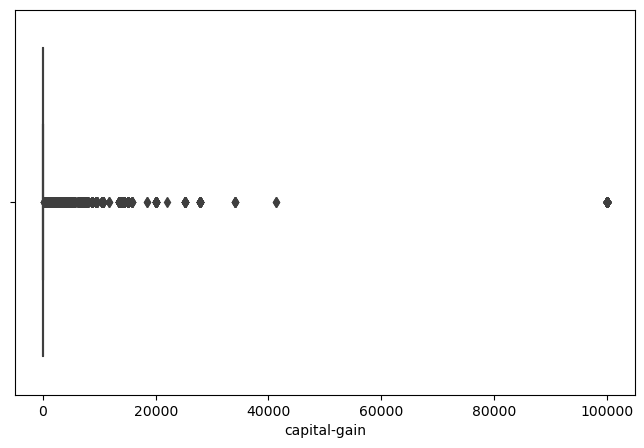

In [46]:
#Boxplot de fnlwgt
plt.rcParams["figure.figsize"] = (8,5)

sns.boxplot(x=quant["capital-gain"])

Dans ce cas, nous observons clairement un point qui est éloigné des autres valeurs de la variable. Ce phénomène aurait une influence sur la partie modélisation que nous voulons éviter. Cependant, nous devons être prudents avec l'élimination des points atypiques puisque cette variable représente la plus-value, qui est censée être fortement corrélée avec la variable cible. Par conséquent, un phénomène rare dans ce cas serait de dépasser un seuil de capital gagné. Ce phénomène peut être rare mais il n'est pas forcément intelligent de l'ignorer. Nous devrions illustrer les points dans un diagramme de dispersion et voir si les plus élevés correspondent à un revenu supérieur à 50 000 dollars par an (ce que nous attendrions d'une relation positive).

[Text(0.5, 1.0, 'Scatterplot pour la variable montant du capital acquis ($)')]

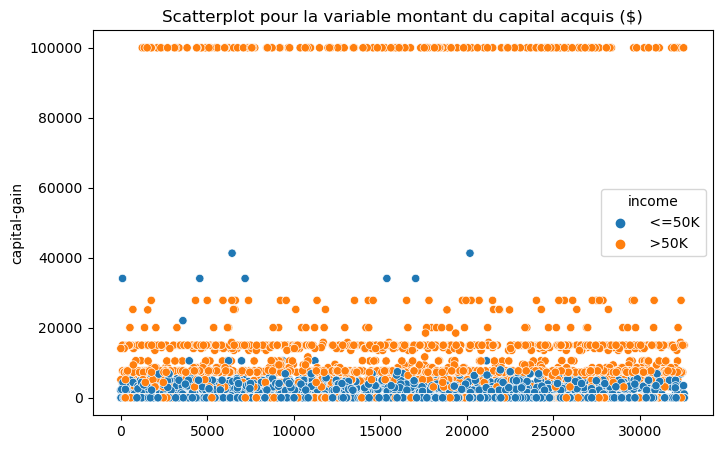

In [47]:
#Scatterplot pour la variable capital-gain
sns.scatterplot(x = train.index, y = train['capital-gain'], hue = train['income']).set(title='Scatterplot pour la variable montant du capital acquis ($)')

Comme tous les points observés au-dessus du seuil de 80 000 dollars remplissent la condition d'un revenu supérieur à $50k/an, nous ne supprimerons aucune ligne. On continue l'analyse avec les variables restantes.

In [48]:
quant2 = pd.DataFrame(data=train, columns=['age','education-num','capital-loss','hours-per-week'])

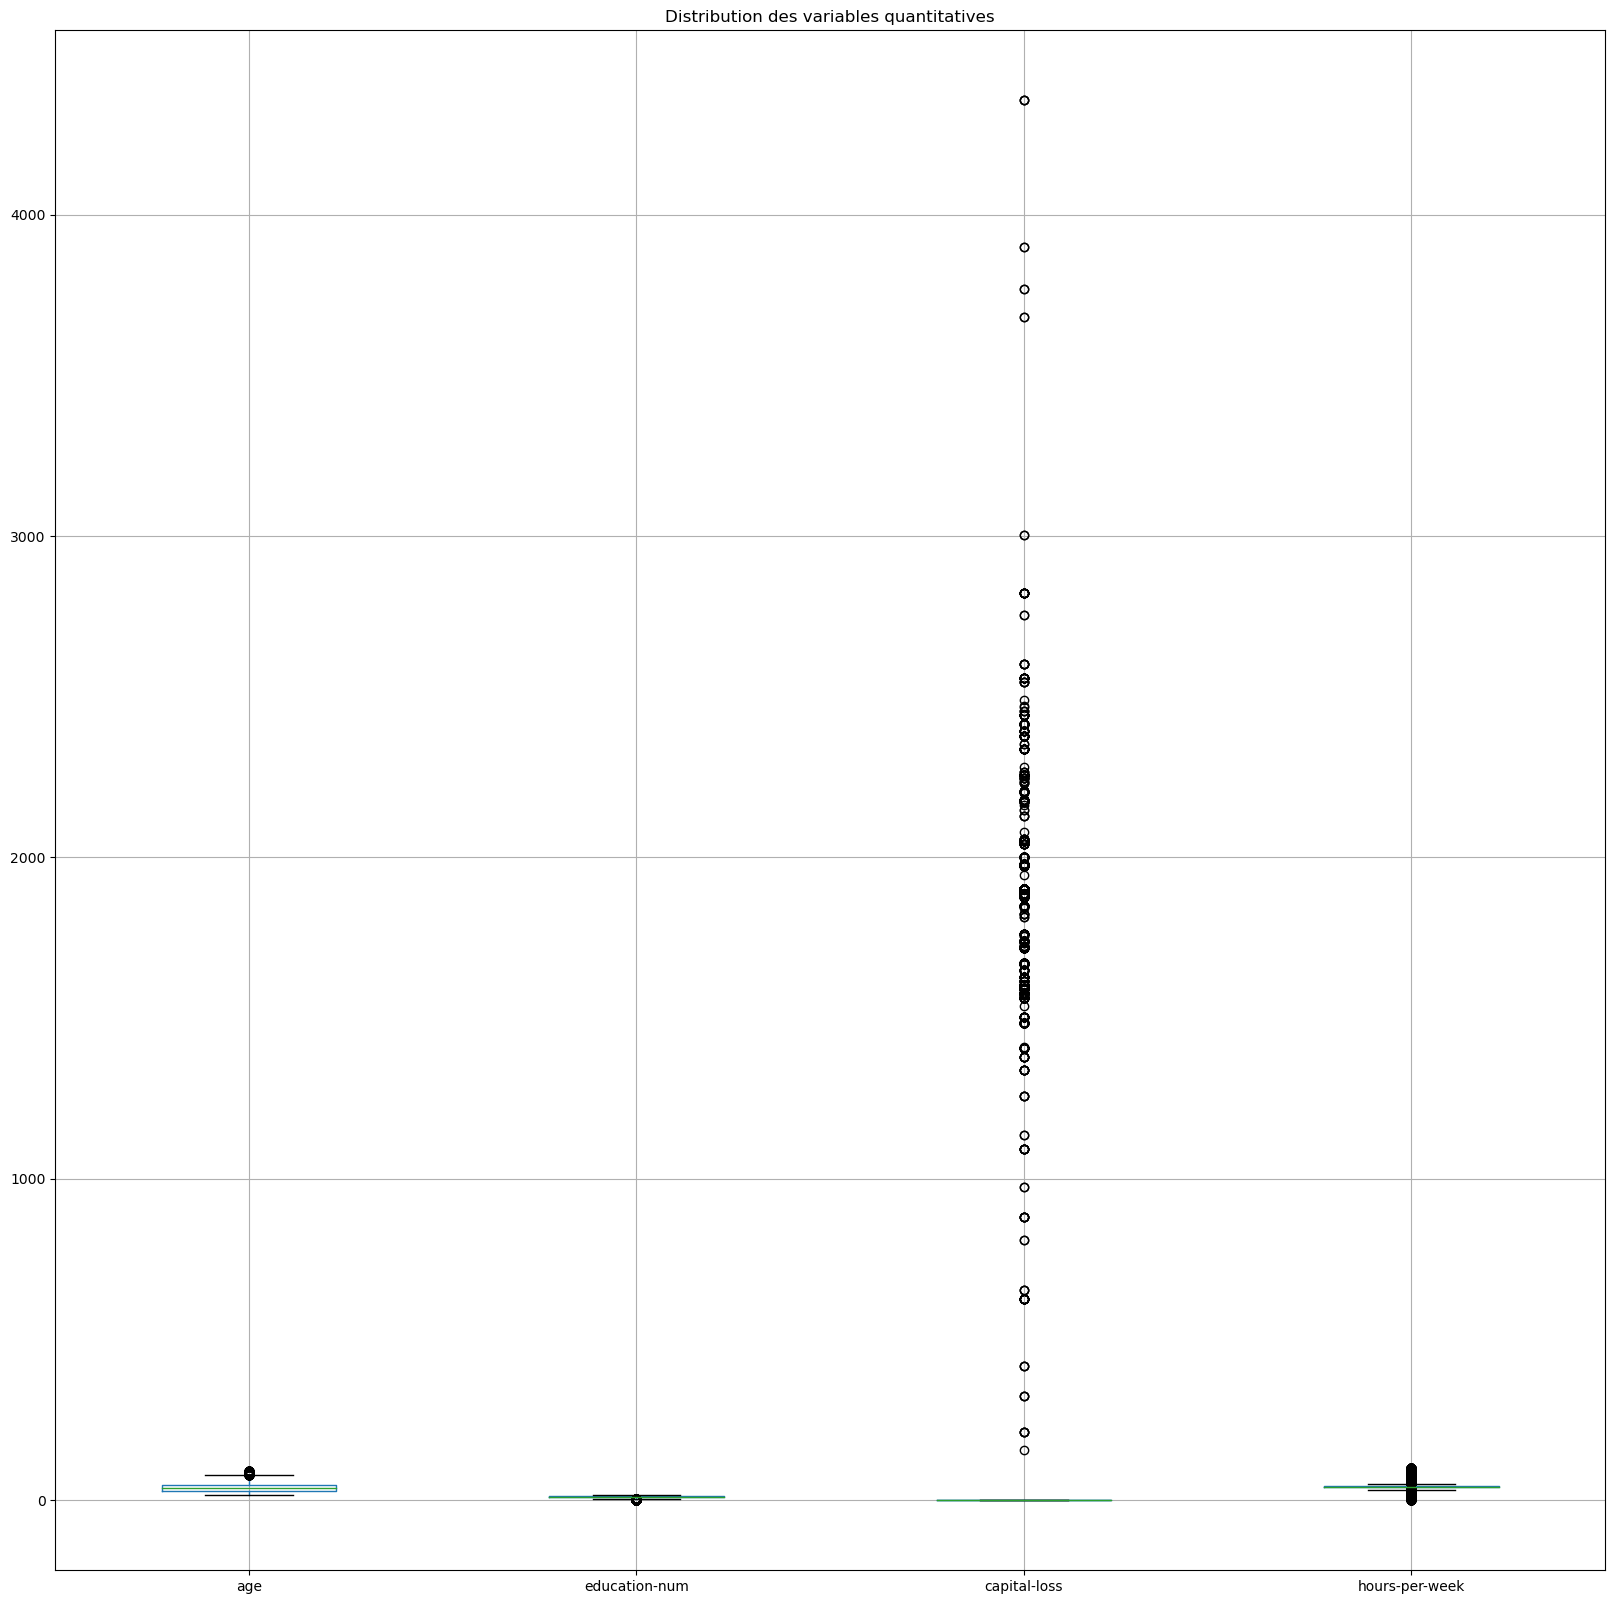

In [49]:
plt.rcParams["figure.figsize"] = (20,20)

quant2.boxplot()
plt.title("Distribution des variables quantitatives")
plt.show()

Pour le cas de la variable __*capital-loss*__, les similitudes avec la variable __*capital-gain*__ sont évidentes. Cependant, les observations les plus élevées ne doivent pas nécessairement correspondre à un revenu inférieur à 50 000 $/an. En effet, les hauts revenus ont tendance à dépenser plus, de sorte que la perte en capital peut refléter cet événement. D'autre part, cela peut également indiquer le cas dans lequel quelqu'un perd un gros investissement et a donc un revenu inférieur. Néanmoins, la variance de ces valeurs n'étant pas très grande, on peut dire que ces points n'auront pas d'influence sur la partie de modélisation.

In [50]:
#Test de Grubbs pour hours-per-week
grubbs_stat(quant['hours-per-week'])

Grubbs Statistics Value : 4.742966730362264


(4.742966730362264, 935)

In [51]:
#Test de Grubbs education-num
grubbs_stat(quant['education-num'])

Grubbs Statistics Value : 3.52965639964022


(3.52965639964022, 224)

In [52]:
#Test de Grubbs age
grubbs_stat(quant['age'])

Grubbs Statistics Value : 3.76961233674322


(3.76961233674322, 222)

Pour les autres variables, les valeurs obtenues pour le test de Grubbs sont inférieures à la valeur critique pour un 5% (4,8057), nous ne pouvons donc pas rejeter l'hypothèse nulle de l'existence d'une _outlier_.

## 2. Modélisation
    
Dans cette partie nous allons créer des modèles de classification avec deux classes. Tout d'abord, nous utiliserons un SVM linéaire et non linéaire. Ensuite, un réseau de neurones avec la librairie Keras sera également implémenté.

### Préparation des données

In [53]:
from sklearn.preprocessing import LabelEncoder
#On doit recoder les variables catégorielles pour que les valeurs soient des nombres et non des chaînes de lettres
#On utilise la démarche du LabelEncoder
le = LabelEncoder()
#On commence avec la base de données d'apprentissage ...
train_label1 = le.fit_transform(train['workclass'])
train_label2 = le.fit_transform(train['education'])
train_label3 = le.fit_transform(train['marital-status'])
train_label4 = le.fit_transform(train['occupation'])
train_label5 = le.fit_transform(train['relationship'])
train_label6 = le.fit_transform(train['race'])
train_label7 = le.fit_transform(train['sex'])
train_label8 = le.fit_transform(train['born'])
train_label9 = le.fit_transform(train['income'])

In [54]:
#On enleve les colonnes originales
train.drop("workclass", axis=1, inplace=True)
train.drop("education", axis=1, inplace=True)
train.drop("marital-status", axis=1, inplace=True)
train.drop("occupation", axis=1, inplace=True)
train.drop("relationship", axis=1, inplace=True)
train.drop("race", axis=1, inplace=True)
train.drop("sex", axis=1, inplace=True)
train.drop("born", axis=1, inplace=True)
train.drop("income", axis=1, inplace=True)
#... et on les remplace par les labels créées
train['workclass'] = train_label1
train['education'] = train_label2
train['marital-status'] = train_label3
train['occupation'] = train_label4
train['relationship'] = train_label5
train['race'] = train_label6
train['sex'] = train_label7
train['born'] = train_label8
train['income'] = train_label9

train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,born,income
31762,61,668362,2,0.0,0.0,40.0,3,3,6,5,1,4,0,1,0
23903,35,668319,13,0.0,1740.0,80.0,1,9,2,3,0,4,1,1,0
3303,47,664821,13,0.0,0.0,40.0,3,9,2,7,0,4,1,0,0
8276,23,664670,9,0.0,0.0,40.0,3,11,4,2,3,2,1,1,0
15087,62,664366,13,0.0,0.0,60.0,3,9,2,11,0,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10826,25,19214,9,0.0,0.0,40.0,3,11,4,5,1,4,1,1,0
24012,26,18827,10,0.0,0.0,40.0,3,15,4,13,1,4,1,1,0
25743,46,14878,15,0.0,0.0,40.0,1,14,2,9,0,1,1,0,1
27207,23,13769,10,0.0,0.0,30.0,3,15,2,6,0,0,1,1,0


In [55]:
#Même demarche pour la base de données test
le = LabelEncoder()
 
test_label1 = le.fit_transform(test['workclass'])
test_label2 = le.fit_transform(test['education'])
test_label3 = le.fit_transform(test['marital-status'])
test_label4 = le.fit_transform(test['occupation'])
test_label5 = le.fit_transform(test['relationship'])
test_label6 = le.fit_transform(test['race'])
test_label7 = le.fit_transform(test['sex'])
test_label8 = le.fit_transform(test['born'])
test_label9 = le.fit_transform(test['income'])

In [56]:
#On enleve les colonnes originales
test.drop("workclass", axis=1, inplace=True)
test.drop("education", axis=1, inplace=True)
test.drop("marital-status", axis=1, inplace=True)
test.drop("occupation", axis=1, inplace=True)
test.drop("relationship", axis=1, inplace=True)
test.drop("race", axis=1, inplace=True)
test.drop("sex", axis=1, inplace=True)
test.drop("born", axis=1, inplace=True)
test.drop("income", axis=1, inplace=True)
#... et on les remplace par les labels créées
test['workclass'] = test_label1
test['education'] = test_label2
test['marital-status'] = test_label3
test['occupation'] = test_label4
test['relationship'] = test_label5
test['race'] = test_label6
test['sex'] = test_label7
test['born'] = test_label8
test['income'] = test_label9

test

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,born,income
0,25,226802,7,0.0,0.0,40.0,3,1,4,6,3,2,1,1,0
1,38,89814,9,0.0,0.0,50.0,3,11,2,4,0,4,1,1,0
2,28,336951,12,0.0,0.0,40.0,1,7,2,10,0,4,1,1,1
3,44,160323,10,7688.0,0.0,40.0,3,15,2,6,0,2,1,1,1
4,18,103497,10,0.0,0.0,30.0,3,15,4,9,3,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,215419,13,0.0,0.0,36.0,3,9,0,9,1,4,0,1,0
16277,64,321403,9,0.0,0.0,40.0,3,11,6,9,2,2,1,1,0
16278,38,374983,13,0.0,0.0,50.0,3,9,2,9,0,4,1,1,0
16279,44,83891,13,5455.0,0.0,40.0,3,9,0,0,3,1,1,1,0


In [57]:
#Comment le jeu de données est déjà découpé en train et test, on va seulement nommer les matrices des variables
X_train = train.drop(['income'], axis=1)
y_train = train[['income']].copy()
X_test = test.drop(['income'], axis=1)
y_test = test[['income']].copy()

In [58]:
y_train.value_counts()

income
0         24656
1          7823
dtype: int64

In [59]:
y_test.value_counts()

income
0         12435
1          3846
dtype: int64

In [60]:
from sklearn.preprocessing import StandardScaler
#On va centrer-réduire les données
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [61]:
# On transforme X_train et X_test avec le calcul de moyenne et l'écart type du X_train
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [62]:
X_test_sc

array([[-0.9960542 ,  0.38535616, -1.19799727, ..., -1.96395623,
         0.70293079,  0.30733277],
       [-0.04338842, -0.9810278 , -0.42057186, ...,  0.39303798,
         0.70293079,  0.30733277],
       [-0.77620825,  1.48403507,  0.74556627, ...,  0.39303798,
         0.70293079,  0.30733277],
       ...,
       [-0.04338842,  1.86338446,  1.13427898, ...,  0.39303798,
         0.70293079,  0.30733277],
       [ 0.39630348, -1.04010664,  1.13427898, ..., -3.14245333,
         0.70293079,  0.30733277],
       [-0.26323437, -0.06004423,  1.13427898, ...,  0.39303798,
         0.70293079,  0.30733277]])

### 2.1. SVM

#### A) Linear SVM

In [71]:
#Linear SVM
l_SVC = LinearSVC(random_state=42, max_iter=2000)
l_SVC.fit(X_train_sc, y_train)

#SVM avec kernel
svc = SVC(kernel='linear',random_state=42)
svc.fit(X_train_sc,y_train)

#SGD classifier
sgdc_svm = SGDClassifier(loss='hinge' ,random_state=42)
sgdc_svm.fit(X_train_sc, y_train)

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SGDClassifier(random_state=42)

In [72]:
#Score de cross validation
cvs_lsvc = cross_val_score(l_SVC, X_train_sc, y_train, cv=5, scoring='accuracy')

cvs_svc = cross_val_score(svc, X_train_sc, y_train, cv=5, scoring='accuracy')

cvs_sgdc = cross_val_score(sgdc_svm, X_train_sc, y_train, cv=5, scoring='accuracy')

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

In [73]:
#Get data output from cross_val_score
df_cross = pd.DataFrame(np.transpose(np.c_[cvs_lsvc,cvs_sgdc,cvs_svc]), 
                        columns=['fold1','fold2','fold3','fold4','fold5'])
#Adding model label
df_cross['model'] = ['lsvc','sgdc','svc']

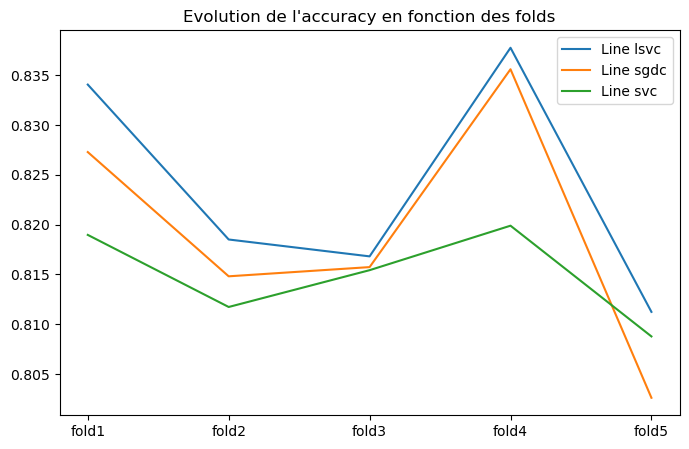

In [76]:
#Regardons l'évolution des scores pour chaque fold
for row in range(df_cross.shape[0]):
    plt.plot( df_cross.iloc[row,0:5] ,label='Line '+str(df_cross.iloc[row,5]))

plt.legend()
plt.title("Evolution de l'accuracy en fonction des folds")
plt.show()

In [77]:
df_cross.head()

,fold1,fold2,fold3,fold4,fold5,model
0,0.834052,0.818504,0.816810,0.837746,0.811239,lsvc
1,0.827278,0.814809,0.815733,0.835591,0.802617,sgdc
2,0.818966,0.811730,0.815425,0.819889,0.808776,svc


In [78]:
for i in range(3):

    mean_model = df_cross.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross.iloc[:,0:5].std(axis=1)[i]
    
    print('Le modèle N° '+ str(i) + ' a une accuray de '  + str(mean_model) + ' et un std : ' + str(std_model))

Le modèle N° 0 a une accuray de 0.8236702967800165 et un std : 0.011556249345156241
Le modèle N° 1 a une accuray de 0.8192057456095443 et un std : 0.012651212894937926
Le modèle N° 2 a une accuray de 0.8149571667481996 et un std : 0.0047230804966721515


Nous observons que le modèle le plus performant a été le *LinearSVC* avec une précision de 82,37%. Nous allons chercher les meilleurs paramètres de ce modèle mais aussi du *SGDClassifier* afin d'avoir un contraste.

#### LinearSVC()

In [95]:
#Obtenir les hyperparamètres de LinearSVC
#On visualise en même temps les valeurs des hyperparamètres par défaut.
LinearSVC().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [96]:
params = {
    "C" : [0.5, 1, 10, 50, 100, 1000],
    "max_iter" : [100, 500, 1000, 2000],
    "loss" : ["hinge","squared_hinge"]    
        }

c_lsvc = LinearSVC(random_state=42)

In [97]:
grid_c_lsvc = GridSearchCV(c_lsvc, param_grid=params, cv=4, return_train_score=True)

In [98]:
take_grid = grid_c_lsvc.fit(X_train_sc, y_train)

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\va

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\va

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\va

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\va

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\va

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\va

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\va

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\va

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [99]:
take_grid.cv_results_

{'mean_fit_time': array([0.16, 0.18, 0.2 , 0.21, 0.35, 1.43, 2.31, 2.79, 0.15, 0.28, 0.32,
        0.32, 0.33, 1.01, 2.05, 5.59, 0.38, 1.53, 1.73, 2.16, 0.33, 1.7 ,
        3.46, 6.6 , 0.37, 1.67, 2.76, 4.92, 0.38, 2.16, 3.83, 6.77, 0.41,
        1.7 , 3.54, 5.89, 0.38, 2.02, 3.87, 7.42, 0.34, 1.74, 3.56, 7.49,
        0.38, 2.03, 4.31, 7.45]),
 'std_fit_time': array([0.01, 0.02, 0.01, 0.02, 0.04, 0.1 , 0.58, 0.55, 0.01, 0.04, 0.02,
        0.06, 0.03, 0.08, 0.27, 0.32, 0.04, 0.18, 0.07, 0.29, 0.02, 0.12,
        0.18, 0.49, 0.01, 0.02, 0.46, 0.9 , 0.03, 0.42, 0.14, 0.48, 0.07,
        0.06, 0.3 , 1.07, 0.12, 0.59, 0.64, 0.3 , 0.03, 0.06, 0.32, 0.25,
        0.03, 0.36, 0.31, 0.47]),
 'mean_score_time': array([0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.  , 0.  

In [100]:
print("La meilleur combinaison d'estimateur est: " + str(take_grid.best_params_)+"\n"
      "pour un score de: " + str(take_grid.best_score_))

La meilleur combinaison d'estimateur est: {'C': 10, 'loss': 'squared_hinge', 'max_iter': 2000}
pour un score de: 0.8239475896410353


<AxesSubplot:title={'center':'Grid search results'}, xlabel='C', ylabel='Mean score'>

<Figure size 600x400 with 0 Axes>

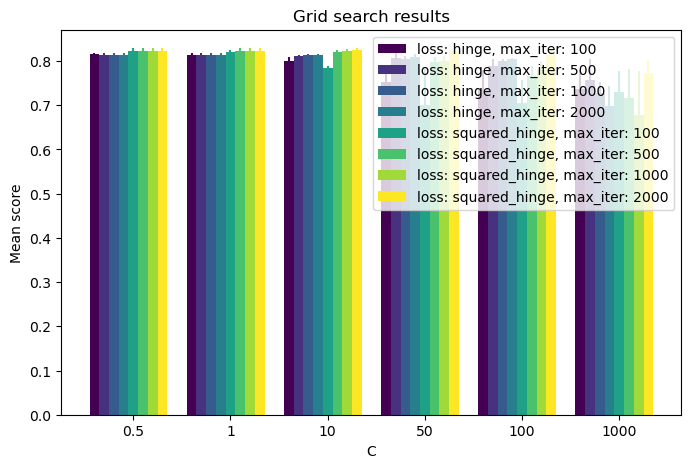

In [101]:
plt.figure(figsize=(6,4))
plot.grid_search(take_grid.cv_results_, change='C', kind='bar')

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

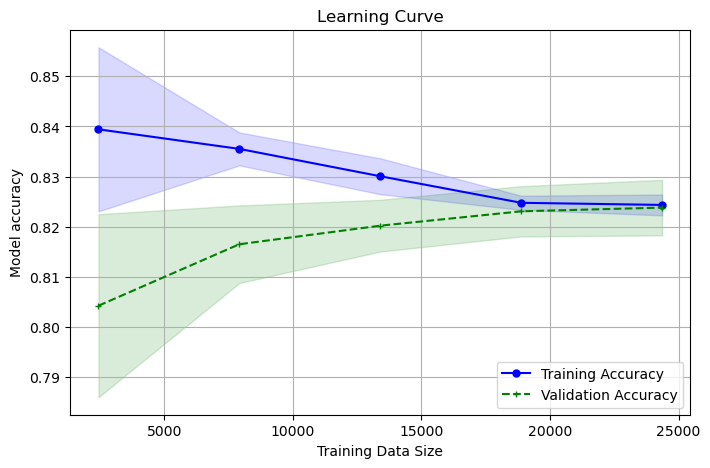

In [129]:
train_sizes, train_scores, test_scores = learning_curve(estimator=c_lsvc, 
                                                        X=X_train_sc, 
                                                        y=y_train,
                                                        cv=4, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )

#
# Trop de fluctuation dans le modèle, on calcule la moyenne des métriques
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [103]:
take_grid.best_params_

{'C': 10, 'loss': 'squared_hinge', 'max_iter': 2000}

In [104]:
best_lsvc = LinearSVC(loss='squared_hinge', max_iter=2000, C=10)

In [105]:
best_lsvc.fit(X_train_sc, y_train)

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC(C=10, max_iter=2000)

<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 300x200 with 0 Axes>

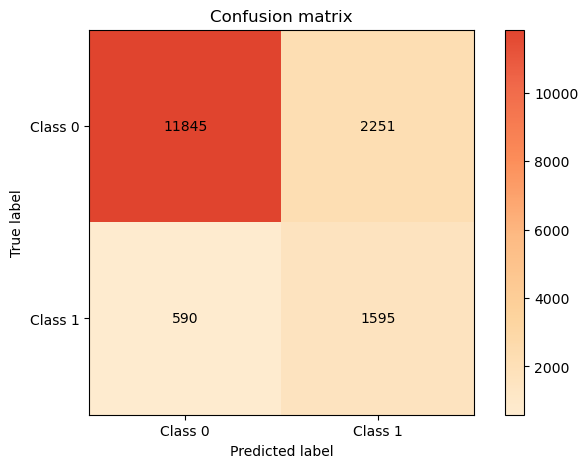

In [106]:
plt.figure(figsize=(3,2))
plot.confusion_matrix(best_lsvc.predict(X_test_sc), y_test.values.ravel())

In [109]:
print(metrics.classification_report(best_lsvc.predict(X_test_sc), y_test.values.ravel()))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     14096
           1       0.41      0.73      0.53      2185

    accuracy                           0.83     16281
   macro avg       0.68      0.79      0.71     16281
weighted avg       0.88      0.83      0.84     16281



In [110]:
print(metrics.accuracy_score(best_lsvc.predict(X_test_sc), y_test.values.ravel()))

0.8255021190344574


Nous pensons qu'en raison des valeurs déséquilibrées de la variable cible, notre modèle a du mal à prédire les individus qui gagnent plus de 50 000 dollars/an. Le taux de faux négatifs est égal à 0,59. Par conséquent, chaque fois que nous entrons dans une nouvelle observation, le modèle prédira très probablement qu'il gagne moins de 50 000 dollars/an. Une bonne solution pourrait être de rééquilibrer l'échantillon.

#### SGDClassifier()

In [81]:
#Obtenir les hyperparamètres de SGDClassifier
#On visualise en même temps les valeurs des hyperparamètres par défaut.
SGDClassifier().get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [82]:
params = {
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "max_iter" : [100, 500, 1000, 2000],
    "validation_fraction" : [0.1, 0.2, 0.3]    
        }

c_sgd = SGDClassifier(random_state=42)

In [83]:
grid_c_sgd = GridSearchCV(c_sgd, param_grid=params, cv=4, return_train_score=True)

In [85]:
take_grid = grid_c_sgd.fit(X_train_sc, y_train)

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

In [86]:
take_grid.cv_results_

{'mean_fit_time': array([0.07924187, 0.07849085, 0.09866148, 0.08244759, 0.09206218,
        0.08956653, 0.07051277, 0.0931977 , 0.10633534, 0.08019978,
        0.09449589, 0.08397865, 0.03769696, 0.05837405, 0.04951239,
        0.05158341, 0.04325342, 0.04327941, 0.04439384, 0.04946661,
        0.05161119, 0.06254292, 0.04291403, 0.05641431, 0.02353293,
        0.03559297, 0.02748829, 0.02355975, 0.04363292, 0.02748632,
        0.02845901, 0.02063507, 0.01947832, 0.03441274, 0.03567189,
        0.02861834, 0.03788924, 0.01559323, 0.01962858, 0.01572138,
        0.01946932, 0.03134477, 0.02343655, 0.02667707, 0.01716423,
        0.0180009 , 0.01962686, 0.03940517]),
 'std_fit_time': array([1.88371612e-02, 4.86898627e-03, 1.86870992e-02, 1.30481946e-02,
        1.92534004e-02, 1.69997734e-02, 7.90495709e-03, 2.94443822e-02,
        2.00278488e-02, 1.80363538e-02, 1.59756549e-02, 1.71299571e-02,
        1.28213359e-02, 8.11373056e-03, 5.75579180e-03, 8.92827250e-03,
        6.96620407e-0

In [87]:
print("La meilleur combinaison d'estimateur est: " + str(take_grid.best_params_)+"\n"
      "pour un score de: " + str(take_grid.best_score_))

La meilleur combinaison d'estimateur est: {'alpha': 0.001, 'max_iter': 100, 'validation_fraction': 0.1}
pour un score de: 0.8187751720558175


<AxesSubplot:title={'center':'Grid search results'}, xlabel='alpha', ylabel='Mean score'>

<Figure size 600x400 with 0 Axes>

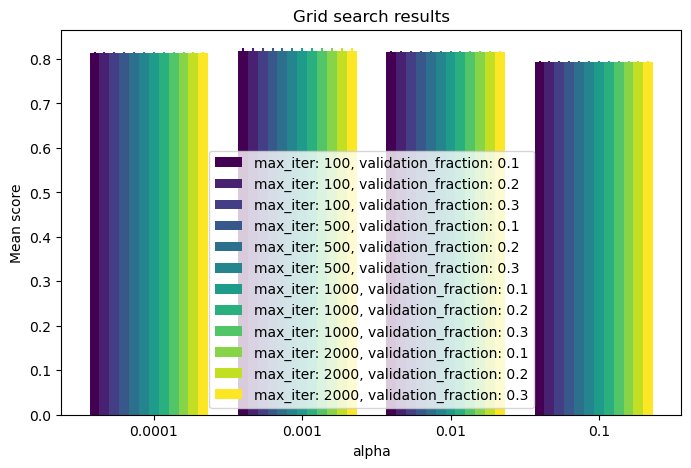

In [88]:
plt.figure(figsize=(6,4))
plot.grid_search(take_grid.cv_results_, change='alpha', kind='bar')

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

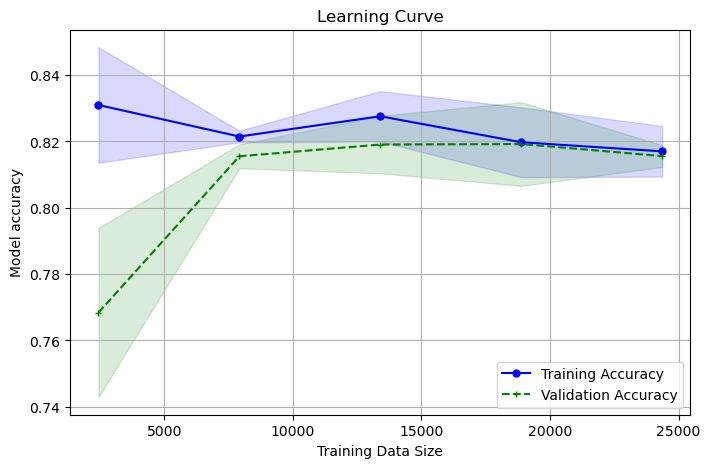

In [89]:
train_sizes, train_scores, test_scores = learning_curve(estimator=c_sgd, 
                                                        X=X_train_sc, 
                                                        y=y_train,
                                                        cv=4, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )

#
# Trop de fluctuation dans le modèle, on calcule la moyenne des métriques
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [90]:
take_grid.best_params_

{'alpha': 0.001, 'max_iter': 100, 'validation_fraction': 0.1}

In [91]:
best_sgd = SGDClassifier(loss='hinge', max_iter=100, validation_fraction=0.1, alpha=0.001)

In [92]:
best_sgd.fit(X_train_sc, y_train)

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SGDClassifier(alpha=0.001, max_iter=100)

<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 300x200 with 0 Axes>

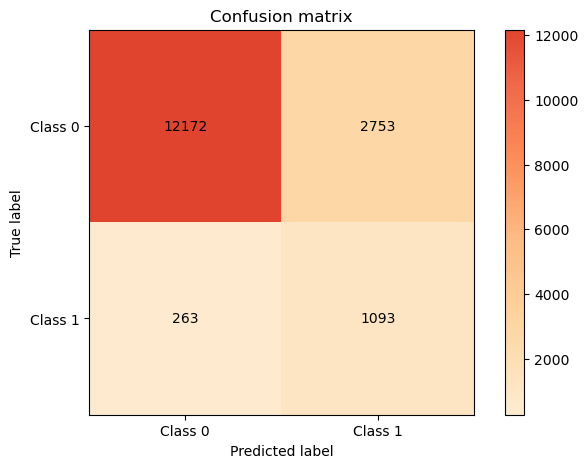

In [94]:
plt.figure(figsize=(3,2))
plot.confusion_matrix(best_sgd.predict(X_test_sc), y_test.values.ravel())

In [111]:
print(metrics.classification_report(best_sgd.predict(X_test_sc), y_test.values.ravel()))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     14925
           1       0.28      0.81      0.42      1356

    accuracy                           0.81     16281
   macro avg       0.63      0.81      0.65     16281
weighted avg       0.92      0.81      0.85     16281



In [112]:
print(metrics.accuracy_score(best_sgd.predict(X_test_sc), y_test.values.ravel()))

0.8147533935261961


Pour le modèle *SGDClassifier* nous obtenons même les pires résultats. Le taux de faux négatifs atteint 0,72. Si nous devions choisir un modèle, nous opterions pour le *LinearSVC*, même si les résultats ne semblent pas très satisfaisants.

#### B) Non-linear SVM

In [114]:
#Polynomial kernel
psvm = SVC(kernel="poly", random_state=42)
psvm.fit(X_train_sc, y_train)

#Radial Basis Function kernel
rbf = SVC(kernel="rbf",  random_state=42)
rbf.fit(X_train_sc, y_train)

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVC(random_state=42)

In [115]:
#Score de cross validation
cvs_psvm = cross_val_score(psvm, X_train_sc, y_train, cv=5, scoring='accuracy')

cvs_rbf = cross_val_score(rbf, X_train_sc, y_train, cv=5, scoring='accuracy')

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

In [116]:
#Get data output from cross_val_score
df_cross = pd.DataFrame(np.transpose(np.c_[cvs_psvm,cvs_rbf]), 
                        columns=['fold1','fold2','fold3','fold4','fold5'])
#Adding model label
df_cross['model'] = ['psvm','rbf']

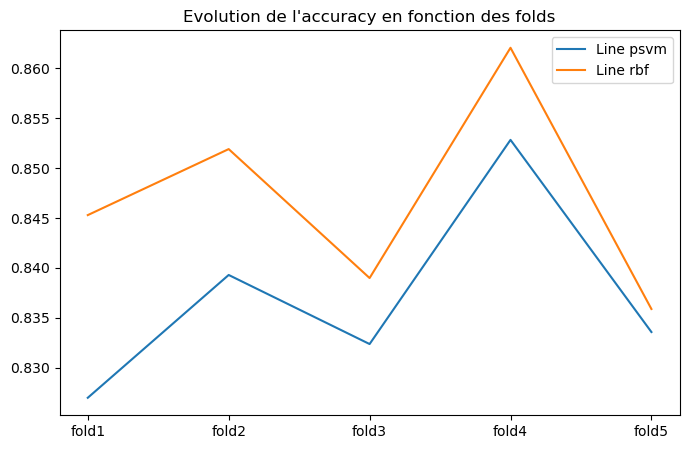

In [117]:
#Regardons l'évolution des scores pour chaque fold
for row in range(df_cross.shape[0]):
    plt.plot( df_cross.iloc[row,0:5] ,label='Line '+str(df_cross.iloc[row,5]))

plt.legend()
plt.title("Evolution de l'accuracy en fonction des folds")
plt.show()

In [118]:
df_cross.head()

,fold1,fold2,fold3,fold4,fold5,model
0,0.826970,0.839286,0.832358,0.852833,0.833564,psvm
1,0.845289,0.851909,0.838978,0.862069,0.835874,rbf


In [119]:
for i in range(2):

    mean_model = df_cross.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross.iloc[:,0:5].std(axis=1)[i]
    
    print('Le modèle N° '+ str(i) + ' a une accuray de '  + str(mean_model) + ' et un std : ' + str(std_model))

Le modèle N° 0 a une accuray de 0.8370022649101052 et un std : 0.00987210433183708
Le modèle N° 1 a une accuray de 0.8468237645858693 et un std : 0.010512970037405624


Les deux modèles semblent mieux fonctionner que les modèles SVM linéaires. Nous allons poursuivre notre analyse avec le modèle *Radial Basis Function* puisqu'il a obtenu un meilleur score.

#### C) Radial Basis Function

In [120]:
#Obtenir les hyperparamètres de LinearSVC
#On visualise en même temps les valeurs des hyperparamètres par défaut.
SVC(kernel='rbf').get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [122]:
params = {
    "kernel" : ["rbf"],
    "gamma" : ["scale","auto"],
    "C" : [0.5, 1, 10, 50, 100, 1000]    
        }

c_rbf = SVC(random_state=42)

In [123]:
grid_c_rbf = GridSearchCV(c_rbf, param_grid=params, cv=4, return_train_score=True)

In [124]:
take_grid = grid_c_rbf.fit(X_train_sc, y_train)

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

In [125]:
print("La meilleur combinaison d'estimateur est: " + str(take_grid.best_params_)+"\n"
      "pour un score de: " + str(take_grid.best_score_))

La meilleur combinaison d'estimateur est: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
pour un score de: 0.8456231756137309


<AxesSubplot:title={'center':'Grid search results'}, xlabel='C', ylabel='Mean score'>

<Figure size 600x400 with 0 Axes>

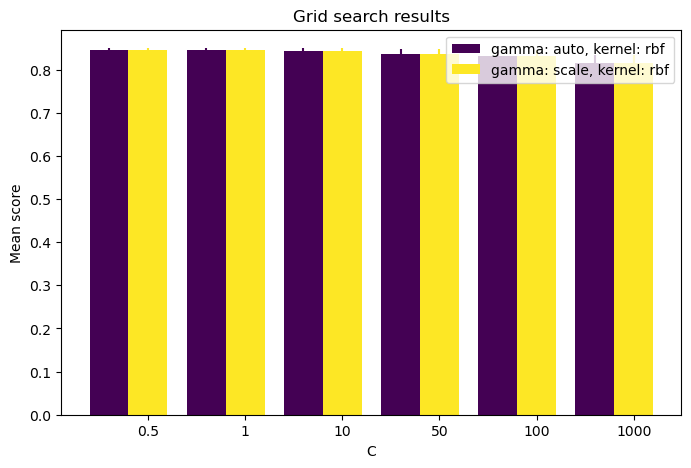

In [126]:
plt.figure(figsize=(6,4))
plot.grid_search(take_grid.cv_results_, change='C', kind='bar')

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\val

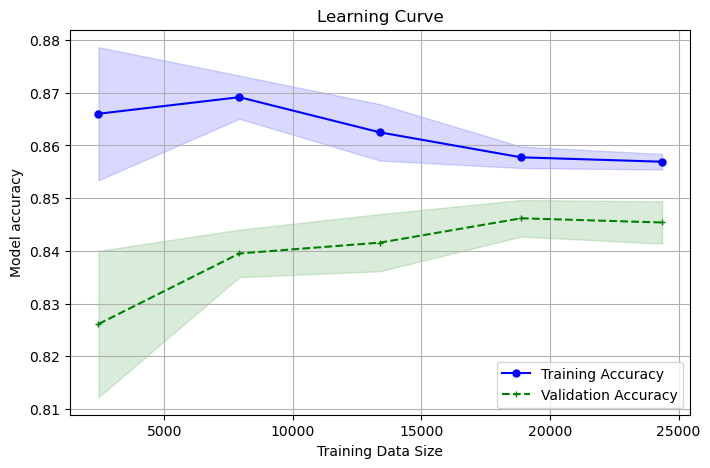

In [137]:
train_sizes, train_scores, test_scores = learning_curve(estimator=c_rbf, 
                                                        X=X_train_sc, 
                                                        y=y_train,
                                                        cv=4, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )

#
# Trop de fluctuation dans le modèle, on calcule la moyenne des métriques
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [130]:
take_grid.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [131]:
best_rbf = SVC(kernel='rbf', C=1, gamma='auto')

In [132]:
best_rbf.fit(X_train_sc, y_train)

C:\Users\carle\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVC(C=1, gamma='auto')

<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 300x200 with 0 Axes>

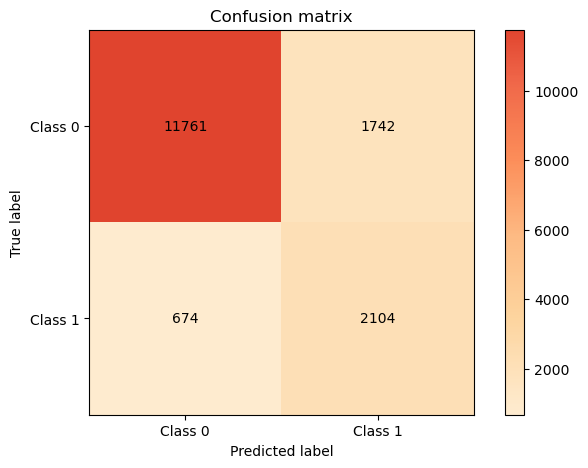

In [133]:
plt.figure(figsize=(3,2))
plot.confusion_matrix(best_rbf.predict(X_test_sc), y_test.values.ravel())

In [134]:
print(metrics.classification_report(best_rbf.predict(X_test_sc), y_test.values.ravel()))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     13503
           1       0.55      0.76      0.64      2778

    accuracy                           0.85     16281
   macro avg       0.75      0.81      0.77     16281
weighted avg       0.88      0.85      0.86     16281



In [135]:
print(metrics.accuracy_score(best_rbf.predict(X_test_sc), y_test.values.ravel()))

0.8516061666973773


On retrouve encore le problème de la classification des faux négatifs (0,45). Néanmoins, ce modèle est plus performant que les SVM linéaires en termes de précision. En revanche, les courbes d'apprentissage ne convergent pas, ce qui signifie que le modèle est sous-ajusté. Cela devrait nécessiter un ensemble d'entraînement plus important afin de réduire la variance.

In [138]:
print('Training score: ' + str(best_rbf.score(X_train_sc,y_train)), 
      '\n',
      'Test score: ' + str(best_rbf.score(X_test_sc, y_test))
     )

Training score: 0.8560300501862742 
 Test score: 0.8516061666973773


On peut pas observer l'importance des variables sur le modèle car il n'est pas linéaire.

### 2.2. Keras

Nous créons un premier modèle avec seulement une couche cachée composée de 300 neurones et une deuxième composée de 100. On a 34701 paramètres dans ce réseau de neurones. La couche output contient 1 biais plus les 100 neurones de la couche cachée précédente.

In [214]:
#Clear session and set seed
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [215]:
#Initialisation du modèle
model = keras.models.Sequential()
#Shape input, number of columns
model.add(keras.layers.Input(shape=X_train.shape[1]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(2))#Output layer

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               4500      
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 34,802
Trainable params: 34,802
Non-trainable params: 0
_________________________________________________________________
None


In [216]:
#Compil model parameter
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer="sgd",
              metrics=["accuracy"])

In [217]:
history = model.fit(X_train_sc, y_train, epochs=30,
                    validation_split=0.2)

Epoch 1/30
812/812 [==============================] - 6s 7ms/step - loss: 8.6172 - accuracy: 0.3128 - val_loss: 11.6717 - val_accuracy: 0.2346
Epoch 2/30
812/812 [==============================] - 6s 7ms/step - loss: 11.5524 - accuracy: 0.2424 - val_loss: 11.6717 - val_accuracy: 0.2346
Epoch 3/30
812/812 [==============================] - 5s 6ms/step - loss: 11.5524 - accuracy: 0.2424 - val_loss: 11.6717 - val_accuracy: 0.2346
Epoch 4/30
812/812 [==============================] - 5s 6ms/step - loss: 11.5524 - accuracy: 0.2424 - val_loss: 11.6717 - val_accuracy: 0.2346
Epoch 5/30
812/812 [==============================] - 5s 6ms/step - loss: 11.5524 - accuracy: 0.2424 - val_loss: 11.6717 - val_accuracy: 0.2346
Epoch 6/30
812/812 [==============================] - 5s 7ms/step - loss: 11.5524 - accuracy: 0.2424 - val_loss: 11.6717 - val_accuracy: 0.2346
Epoch 7/30
812/812 [==============================] - 5s 7ms/step - loss: 11.5524 - accuracy: 0.2424 - val_loss: 11.6717 - val_accuracy: 

In [218]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_pred

509/509 [==============================] - 2s 4ms/step


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 300x200 with 0 Axes>

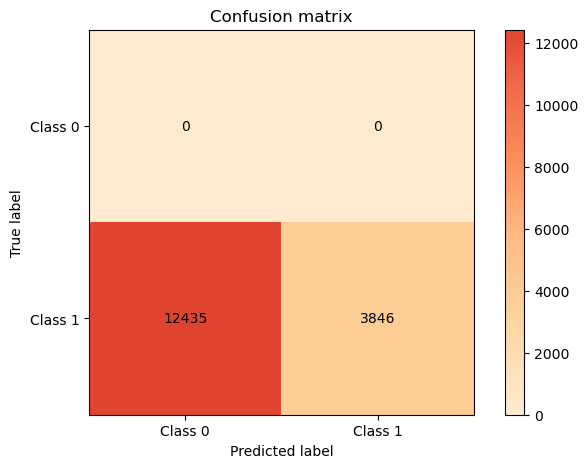

In [219]:
plt.figure(figsize=(3,2))
plot.confusion_matrix(y_pred, y_test.values.ravel())

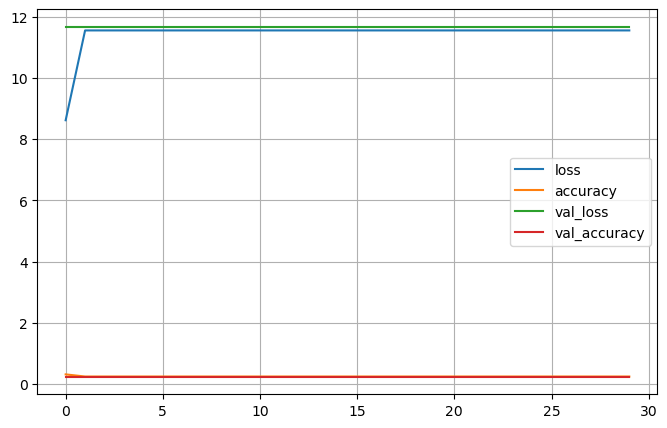

In [220]:
#Graphique du loss
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [221]:
model.evaluate(X_test, y_test)

509/509 [==============================] - 2s 4ms/step - loss: 11.6470 - accuracy: 0.2362


[11.647001266479492, 0.23622627556324005]

In [226]:
#Clear session and set seed
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [227]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(15,input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                225       
                                                                 
 dense_1 (Dense)             (None, 100)               1600      
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 12,026
Trainable params: 12,026
Non-trainable params: 0
_________________________________________________________________
None


In [228]:
#Fonction de perte
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
train_model = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
1015/1015 [==============================] - 6s 5ms/step - loss: 316.1678 - accuracy: 0.6635 - val_loss: 256.5883 - val_accuracy: 0.7865
Epoch 2/30
1015/1015 [==============================] - 5s 5ms/step - loss: 100.3160 - accuracy: 0.6809 - val_loss: 35.1438 - val_accuracy: 0.7926
Epoch 3/30
1015/1015 [==============================] - 5s 5ms/step - loss: 57.5950 - accuracy: 0.6811 - val_loss: 20.5206 - val_accuracy: 0.7933
Epoch 4/30
1015/1015 [==============================] - 4s 4ms/step - loss: 37.6176 - accuracy: 0.6876 - val_loss: 66.8736 - val_accuracy: 0.2362
Epoch 5/30
1015/1015 [==============================] - 5s 5ms/step - loss: 22.0331 - accuracy: 0.6855 - val_loss: 7.3645 - val_accuracy: 0.2362
Epoch 6/30
1015/1015 [==============================] - 4s 4ms/step - loss: 11.4737 - accuracy: 0.6892 - val_loss: 6.5101 - val_accuracy: 0.7952
Epoch 7/30
1015/1015 [==============================] - 5s 5ms/step - loss: 7.2618 - accuracy: 0.6887 - val_loss: 6.6334 - 

In [231]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_pred

509/509 [==============================] - 1s 1ms/step


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 300x200 with 0 Axes>

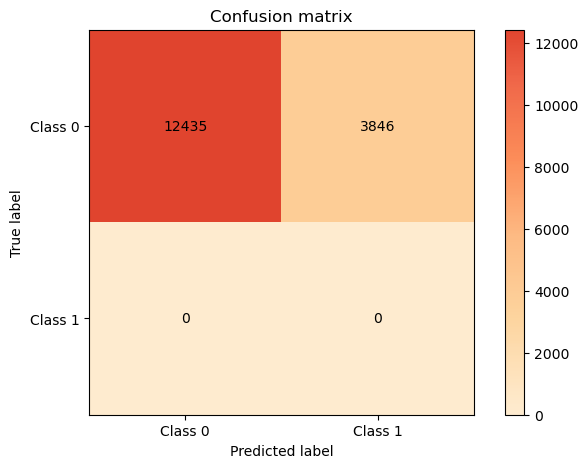

In [232]:
plt.figure(figsize=(3,2))
plot.confusion_matrix(y_pred, y_test.values.ravel())

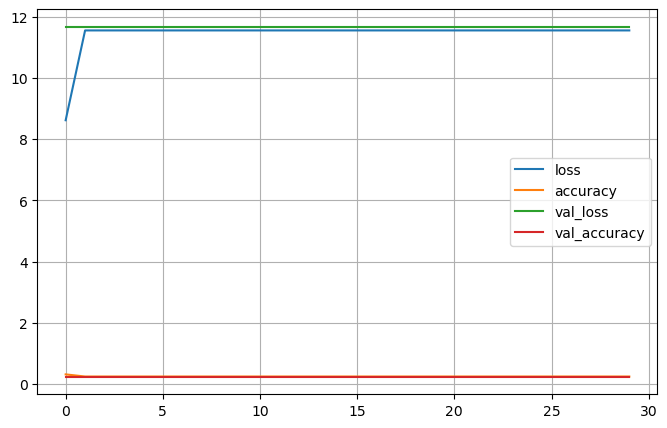

In [233]:
#Graphique du loss
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()